In [82]:
import numpy as np
import pandas as pd
import h5py


In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
import os
import sys
import glob
import readsnapsgl
from utils import rotate_data
from matplotlib import colors
from matplotlib import cm
#from pymsz.rotate_data import SPH_smoothing

In [84]:
mean_mol_weight = 0.588
prtn = 1.67373522381e-24  # (proton mass in g)
bk = 1.3806488e-16        # (Boltzman constant in CGS)

cosm = FlatLambdaCDM(H0=67.77, Om0=0.307115)

In [85]:
sph_data_dir = '/data7/NIKA2-300th/rwicker/Weiguang_sph_tests'
plot_dir = '/home/rwicker/plots'

In [86]:
NIKA2_TS_df = pd.read_csv(f'/home2/ferragamo/NIKA2_300_TS/NIKA2-TS_clusters_list.csv')
NIKA2_TS_df

rid              hid  snap  redshift                LPSZ_ShortName  \
0     18  110000000000001   110     0.490  PSZ2G228, PSZ2G111, PSZ2G111   
1     39  110000000000001   110     0.490  PSZ2G111, PSZ2G155, PSZ2G155   
2    110  110000000000001   110     0.490                      PSZ2G155   
3     24  110000000000001   110     0.490            PSZ2G201, PSZ2G045   
4     36  110000000000001   110     0.490                      PSZ2G144   
..   ...              ...   ...       ...                           ...   
117   29  101000000000001   101     0.817                      PSZ2G091   
118   46  101000000000001   101     0.817                      PLCKG227   
119   84  101000000000001   101     0.817                      PSZ2G160   
120  306  101000000000001   101     0.817                      PSZ2G104   
121  216  101000000000001   101     0.817                      ACTJ0215   

                          TS  
0    Tot_Mass, HE_Mass, Y500  
1    Tot_Mass, HE_Mass, Y500  
2                   Tot_Mass  
3          Tot_Mass, HE_Mass  
4                   Tot_Mass  
..                       ...  
117                     Y500  
118                     Y500  
119                     Y500  
120                     Y500  
121                     Y500  

[122 rows x 6 columns]

In [87]:
NIKA2_morpho_par_df = pd.read_csv('/data7/NIKA2-300th/Data_Base/Nika2_twin_sample_chi_par.csv')
NIKA2_morpho_par_df

rid           hid  DS_200   eta_200  detla_200    fm_200   fm2_200  \
0      4.0  1.100000e+14     0.0  1.077337   0.044355  0.104659  0.016860   
1      5.0  1.100000e+14     0.0  1.494543   0.131594  0.202382  0.077620   
2     17.0  1.100000e+14     0.0  1.115010   0.042787  0.137806  0.020684   
3     18.0  1.100000e+14     0.0  1.032552   0.130457  0.138719  0.046699   
4     21.0  1.100000e+14     0.0  1.600101   0.059620  0.231709  0.036553   
..     ...           ...     ...       ...        ...       ...       ...   
117  152.0  1.010000e+14     0.0  1.135816   0.071233  0.142618  0.026700   
118  211.0  1.010000e+14     0.0  1.169360   0.097010  0.187474  0.077763   
119  216.0  1.010000e+14     0.0  1.387865   0.064533  0.165399  0.029497   
120  221.0  1.010000e+14     0.0  1.171327   0.011771  0.114417  0.025637   
121  306.0  1.010000e+14     0.0  1.217596   0.109861  0.191900  0.088536   

     DS_500   eta_500  detla_500    fm_500   fm2_500  Chi500_DL  \
0       0.0  1.119686   0.061044  0.117297  0.024969   1.069504   
1       0.0  1.539348   0.176059  0.205304  0.100589   0.522900   
2       0.0  1.216516   0.032932  0.124885  0.028339   1.094978   
3       0.0  1.020049   0.072624  0.047405  0.005205   1.630669   
4       0.0  1.325415   0.048964  0.227190  0.050688   0.608509   
..      ...       ...        ...       ...       ...        ...   
117     0.0  1.194097   0.066588  0.153248  0.034752   0.846383   
118     0.0  0.990404   0.120771  0.229189  0.107582   0.545898   
119     0.0  1.416488   0.071019  0.159253  0.037925   0.811038   
120     0.0  1.194987   0.027064  0.081393  0.021289   1.648767   
121     0.0  1.143490   0.097035  0.093066  0.020885   1.051843   

     Chi500_fm2_DL  Chi500_H  Chi500_fm2_H  Chi200_DL  Chi200_fm2_DL  \
0         2.144274  1.202667      1.375207   1.244140       2.980348   
1         0.697454  3.613297      3.616062   0.585831       0.925652   
2         3.255060  1.850495      2.457768   0.980081       2.975786   
3         1.942334  0.932670      0.962916   0.742658       1.020624   
4         2.006684  2.270878      2.532886   0.591087       2.022218   
..             ...       ...           ...        ...            ...   
117       1.882837  1.503448      1.646735   0.887110       1.859028   
118       0.874381  0.461387      0.544158   0.669969       1.137461   
119       1.756545  2.869988      2.935915   0.796550       1.993125   
120       4.107124  2.089918      2.766380   1.229528       5.013102   
121       1.424797  1.165962      1.192108   0.639561       1.002309   

     Chi200_H  Chi200_fm2_H  
0    1.247469      1.628043  
1    3.327307      3.336533  
2    1.254460      1.765029  
3    0.534721      0.568741  
4    4.049770      4.156822  
..        ...           ...  
117  1.181587      1.320979  
118  1.262560      1.318061  
119  2.692237      2.793117  
120  1.858493      4.582491  
121  1.540001      1.569914  

[122 rows x 20 columns]

In [88]:
NIKA2_TS_df = NIKA2_TS_df.merge(NIKA2_morpho_par_df[['rid', 'hid', 'Chi500_DL', 'Chi500_H',  'Chi200_DL', 'Chi200_H']], how='inner', on=['rid', 'hid'])

In [89]:
NIKA2_TS_df

rid              hid  snap  redshift                LPSZ_ShortName  \
0     18  110000000000001   110     0.490  PSZ2G228, PSZ2G111, PSZ2G111   
1     39  110000000000001   110     0.490  PSZ2G111, PSZ2G155, PSZ2G155   
2    110  110000000000001   110     0.490                      PSZ2G155   
3     24  110000000000001   110     0.490            PSZ2G201, PSZ2G045   
4     36  110000000000001   110     0.490                      PSZ2G144   
..   ...              ...   ...       ...                           ...   
117   29  101000000000001   101     0.817                      PSZ2G091   
118   46  101000000000001   101     0.817                      PLCKG227   
119   84  101000000000001   101     0.817                      PSZ2G160   
120  306  101000000000001   101     0.817                      PSZ2G104   
121  216  101000000000001   101     0.817                      ACTJ0215   

                          TS  Chi500_DL  Chi500_H  Chi200_DL  Chi200_H  
0    Tot_Mass, HE_Mass, Y500   1.630669  0.932670   0.742658  0.534721  
1    Tot_Mass, HE_Mass, Y500   1.115518  1.417933   0.653853  1.198451  
2                   Tot_Mass   1.641766  5.573558   1.329339  5.411670  
3          Tot_Mass, HE_Mass   0.576334  3.764748   0.539518  6.286937  
4                   Tot_Mass   0.563566  1.502813   0.427653  0.865041  
..                       ...        ...       ...        ...       ...  
117                     Y500   0.778144  1.925464   0.684564  1.285298  
118                     Y500   1.219690  2.026258   1.094511  1.710208  
119                     Y500   1.047252  6.645440   1.059759  6.898295  
120                     Y500   1.051843  1.165962   0.639561  1.540001  
121                     Y500   0.811038  2.869988   0.796550  2.692237  

[122 rows x 10 columns]

In [90]:
for i, (crn, sn, hid, name, ts, chi200_dl, chi200_h, chi500_dl, chi500_h) in enumerate(zip(NIKA2_TS_df.rid, NIKA2_TS_df.snap, NIKA2_TS_df.hid, 
                                                                                           NIKA2_TS_df.LPSZ_ShortName, NIKA2_TS_df.TS,
                                                                                           NIKA2_TS_df.Chi200_DL, NIKA2_TS_df.Chi200_H,
                                                                                           NIKA2_TS_df.Chi500_DL, NIKA2_TS_df.Chi500_H)):
    print(crn, sn, hid,name, ts, chi200_dl, chi200_h, chi500_dl, chi500_h)
    break


crn = 9
cn = f'NewMDCLUSTER_{crn:04d}'

sn = 104
snapn = f'snap_{sn:03d}'

cn, snapn

18 110 110000000000001 PSZ2G228, PSZ2G111, PSZ2G111 Tot_Mass, HE_Mass, Y500 0.742657871399003 0.5347208644976129 1.6306686486154895 0.932669702113864


('NewMDCLUSTER_0009', 'snap_104')

In [91]:
#=======================================================
#simulation = 'Gizmo-Simba'
simulation = 'GadgetX'

if simulation == 'Gizmo-Simba':
    Xspath = "/home2/weiguang/data7/Gizmo-Simba/"
    filename = f'{Xspath}{cn}/{snapn}.hdf5'
    progenIDs = np.loadtxt("/home2/weiguang/Project-300-Clusters/Halo_mass_function_mass-difference/GIZMO/Progenitor-IDs-for-center-cluster.txt",dtype=np.int64)
    tmpd = np.load(f'/home2/weiguang/Project-300-Clusters/Halo_mass_function_mass-difference/GIZMO/GS_Mass_snap_{sn:03d}info.npy')
elif simulation == 'GadgetX':
    Xspath = '/data4/niftydata/TheThreeHundred/data/simulations/GadgetX/'
    filename = f'{Xspath}{cn}/{snapn}'
    progenIDs = np.loadtxt("/home2/weiguang/Project-300-Clusters/Halo_mass_function_mass-difference/GadgetX/Progenitor-IDs-for-center-cluster.txt",dtype=np.int64)
    tmpd = np.load(f'/home2/weiguang/Project-300-Clusters/Halo_mass_function_mass-difference/GadgetX/G3X_Mass_snap_{sn:03d}info.npy')

sn_sa_red = np.loadtxt('/home2/weiguang/Project-300-Clusters/redshifts.txt')
#filename

In [92]:
sn_sa_red = np.loadtxt('/home2/weiguang/Project-300-Clusters/redshifts.txt')
sn_sa_red
kk = np.array([i[2] for i in sn_sa_red])

In [93]:
if simulation == 'Gizmo-Simba':
    file_data = h5py.File(filename, 'r')
    v_unit = 1.0e5 * np.sqrt(f['Header'].attrs['Time'])  # (e.g. 1.0 km/sec)
elif simulation == 'GadgetX':
    head = readsnapsgl.readsnap(filename, block = 'HEAD', quiet=True, ptype=0)
    v_unit = 1.0e5 * np.sqrt(head.Time)  # (e.g. 1.0 km/sec)

m_ptoMsun = const.m_p.to('Msun').value #proton mass in unit Msun
KtokeV = const.k_B.value / const.e.value * 1e-3 # [K] to [keV] == k_B*T
kinunit = 1/ u.keV.to('Msun km2 s-2') #from Msun*(km/s)^2 to keV

In [94]:
#ReginIDs HIDs  HosthaloID Mvir(4) Xc(5)   Yc(6)   Zc(7)  Rvir(8) fMhires(38) cNFW (42) Mgas200 M*200 M500(13)  R500(14) fgas500 f*500
ids = np.where((np.int32(tmpd[:,0])==crn) & (np.int64(tmpd[:,1]) == progenIDs[crn-1, sn]))[0]

cc = tmpd[ids, 4:7][0]
r200 = tmpd[ids, 7][0]
r500 = tmpd[ids, 13][0]
M500 = tmpd[ids, 12][0]*1.e10
M200 = tmpd[ids,3][0]
#print(M200, r200, cc)
print(r500, r200)
prop = { 'cc':cc,'r200':r200}

1396.3348431655181 2151.59


In [95]:
j = 0 #particle type: 0: gas; 1: DM; 4: stars

if simulation == 'Gizmo-Simba':
    vel_g = file_data[f'PartType{j}/Velocities'][:]
    pos_g = file_data[f'PartType{j}/Coordinates'][:]
    #rr_g = np.sqrt(np.sum((pos_g-prop['cc'])**2, axis=1))
    mas_g = file_data[f'PartType{j}/Masses'][:]
    sgden_g = file_data[f'PartType{j}/Density'][:] * 1.0e10 /0.6777/(1/0.6777)**3  #in Msun/kpc^3
    # temp = file_data[f'PartType{j}/InternalEnergy'][:] * (5. / 3 - 1) * v_unit**2 * prtn * mean_mol_weight / bk # in k
    temp_g = readsnapsgl.readhdf5data(filename, block = 'temperature', quiet=True, ptype=j) #in K
    eleab_g = file_data[f'PartType{j}/ElectronAbundance'][:]
    #wind = file_data[f'PartType{j}/NWindLaunches'][:]
    delaytime_g = f[f'PartType{j}/DelayTime'][:]
    sfr_g = file_data[f'PartType{j}/StarFormationRate'][:]
    metl_g = file_data[f'PartType{j}/Metallicity'][:]
    pot_g = file_data[f'PartType{j}/Potential'][:]
    metHe_g = metl_g[:,1] #He 
    metM_g = metl_g[:,0] #metallicity
    nH_g = (1 - metHe_g - metM_g)*mas_g*1.0e10 / 0.6777  #proton number 
    ne_g = nH_g * eleab_g #electron number: proton number multiply relative value

elif simulation == 'GadgetX':
    vel_g = readsnapsgl.readsnap(filename, block = 'VEL ', quiet=True, ptype=j)
    pos_g = readsnapsgl.readsnap(filename, block = 'POS ', quiet=True, ptype=j)
    #rr_g = np.sqrt(np.sum((pos_g-prop['cc'])**2, axis=1))
    mas_g = readsnapsgl.readsnap(filename, block = 'MASS', quiet=True, ptype=j)
    sgden_g = readsnapsgl.readsnap(filename, block = 'RHO ', quiet=True, ptype=j) * 1.0e10 /0.6777/(1/0.6777)**3  #in Msun/kpc^3
    temp_g = readsnapsgl.readsnap(filename, block = 'TEMP', quiet=True, ptype=j)
    eleab_g = readsnapsgl.readsnap(filename, block = 'NE  ', quiet=True, ptype=j)
    sfr_g = readsnapsgl.readsnap(filename, block = 'SFR ', quiet=True, ptype=j)
    metHe_g = 0.24 #He 
    metM_g = readsnapsgl.readsnap(filename, block = 'Z   ', quiet=True, ptype=j) #total metallicity
    nH_g = (1 - metHe_g - metM_g)*mas_g*1.0e10 / 0.6777  #proton number 
    ne_g = nH_g * eleab_g #electron number: proton number multiply relative value
    smoothing_length = readsnapsgl.readsnap(filename, block='HSML', quiet=True, ptype=j)


[505.58005  531.6706   578.3866   ...  30.857979  30.588623  46.44362 ]


(array([3.43459e+05, 6.13607e+05, 6.66057e+05, 5.95551e+05, 5.18099e+05,
        4.65539e+05, 4.31672e+05, 3.91738e+05, 3.48041e+05, 2.99869e+05,
        2.52388e+05, 2.10583e+05, 1.74915e+05, 1.48984e+05, 1.28238e+05,
        1.12245e+05, 9.81430e+04, 8.61130e+04, 7.72190e+04, 6.88450e+04,
        6.24330e+04, 5.56970e+04, 4.91560e+04, 4.40470e+04, 3.83100e+04,
        3.32270e+04, 2.81090e+04, 2.37260e+04, 1.95710e+04, 1.61690e+04,
        1.26150e+04, 1.00390e+04, 7.73800e+03, 6.14000e+03, 4.79200e+03,
        3.76000e+03, 2.64400e+03, 1.87900e+03, 1.33900e+03, 8.80000e+02,
        6.57000e+02, 4.51000e+02, 3.23000e+02, 2.22000e+02, 1.64000e+02,
        1.56000e+02, 1.32000e+02, 9.50000e+01, 6.80000e+01, 6.70000e+01,
        5.10000e+01, 5.00000e+01, 4.10000e+01, 3.00000e+01, 3.70000e+01,
        3.30000e+01, 3.80000e+01, 2.60000e+01, 2.20000e+01, 2.40000e+01,
        2.30000e+01, 1.60000e+01, 1.00000e+01, 1.20000e+01, 1.50000e+01,
        8.00000e+00, 1.60000e+01, 1.10000e+01, 1.20

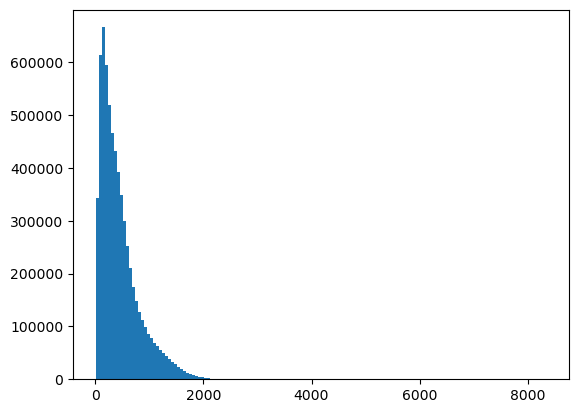

In [96]:
print(smoothing_length)
plt.hist(smoothing_length, bins=150)

In [97]:
center = np.median(pos_g, axis=0)
print(center, center.shape)

[500604.94 499062.78 500827.94] (3,)


In [98]:
rott = np.loadtxt('/home2/ferragamo/NIKA2_300_TS/29_rotations.txt')
for irot, RA in enumerate(rott):
    RA = rott[0]
    pos_g, vel_g, _= rotate_data(pos_g, RA, vel=vel_g, bvel=None)
    prop['cc'], _, _= rotate_data(prop['cc'], RA, vel=None, bvel=None)
    rr_g = np.sqrt(np.sum((pos_g-prop['cc'])**2, axis=1))
    break

In [99]:
print(prop['cc'], prop['cc'].shape)
print(pos_g.shape)

[500449.25180608 498686.08206418 500729.06224462] (3,)
(6456598, 3)


In [100]:
test_array = pos_g-prop['cc']
print(test_array.shape, test_array)

(6456598, 3) [[-17838.87680608   -633.61331418  -5373.06224462]
 [-17882.68930608   -437.36331418  -5431.43724462]
 [-17981.68930608   -432.39456418  -5451.21849462]
 ...
 [  -629.31430608  -5279.58206418   1373.37525538]
 [  -626.03305608  -5279.42581418   1376.34400538]
 [  -618.56430608  -5261.80081418   1382.15650538]]


In [101]:
pos_x = np.array([pos[0]-prop['cc'][0] for pos in pos_g])
pos_y = np.array([pos[1]-prop['cc'][1] for pos in pos_g])
pos_z = np.array([pos[2]-prop['cc'][2] for pos in pos_g])

### Selection of particle within the cube

In [102]:
r200_frac = 2
pixel_size = 10

In [103]:
#particle conditions
temp_limit = 1.0e6 #5.8e6
dens_limit = 2.88e6
if simulation == 'Gizmo-Simba':
        ids0 = [(np.abs(pos_x) <= r200_frac*prop['r200']) & 
                (np.abs(pos_y) <= r200_frac*prop['r200']) & 
                (np.abs(pos_z) <= r200_frac*prop['r200']) &
                (temp_g > temp_limit) & 
                (delaytime_g <= 0) &
                (sgden_g < dens_limit)][0]
if simulation == 'GadgetX':
        ids0 = [(np.abs(pos_x) <= r200_frac*prop['r200']) & 
                (np.abs(pos_y) <= r200_frac*prop['r200']) & 
                (np.abs(pos_z) <= r200_frac*prop['r200']) &
                (temp_g > temp_limit) & 
                (sgden_g < dens_limit)][0]

rr = rr_g[ids0]
mas = mas_g[ids0]*1.0e10
temp = temp_g[ids0]
temp = temp*KtokeV
vel = vel_g[ids0]
sgden = sgden_g[ids0]
hubblev = pos_g[ids0] / 0.6777 * 67.77 / 1e3 #Hubble flow; unit: km/s
vv = vel + hubblev
ne = ne_g[ids0]
metM = metM_g[ids0]
smoothing_length = smoothing_length[ids0]

if simulation == 'Gizmo-Simba':
        pot = pot_g[ids0]
        
kin_energy_gas = np.sum(vel**2,axis=1,dtype=np.float64)*mas/2./0.6777 #unit: Msun (km/s)^2
them_energy_gas = 3.*KtokeV*mas / 0.6777 * temp / 2. #unit: keV

x = pos_x[ids0]
y = pos_y[ids0]
z = pos_z[ids0]

In [104]:
#redshift = prop['z']
#print(redshift)
print(sn_sa_red)

[[0.00000000e+00 5.56135438e-02 1.69812317e+01]
 [1.00000000e+00 6.04962856e-02 1.55299397e+01]
 [2.00000000e+00 6.16382807e-02 1.52236834e+01]
 [3.00000000e+00 6.28018379e-02 1.49231014e+01]
 [4.00000000e+00 6.45884797e-02 1.44826374e+01]
 [5.00000000e+00 6.58077225e-02 1.41957846e+01]
 [6.00000000e+00 6.70499802e-02 1.39142466e+01]
 [7.00000000e+00 6.89574778e-02 1.35016899e+01]
 [8.00000000e+00 7.02591985e-02 1.32330122e+01]
 [9.00000000e+00 7.22579956e-02 1.28392992e+01]
 [1.00000000e+01 7.36220181e-02 1.25828934e+01]
 [1.10000000e+01 7.50117898e-02 1.23312378e+01]
 [1.20000000e+01 7.71457925e-02 1.19624701e+01]
 [1.30000000e+01 7.86020830e-02 1.17223101e+01]
 [1.40000000e+01 8.00858587e-02 1.14865990e+01]
 [1.50000000e+01 8.23642164e-02 1.11411953e+01]
 [1.60000000e+01 8.39190111e-02 1.09162502e+01]
 [1.70000000e+01 8.55031610e-02 1.06954737e+01]
 [1.80000000e+01 8.79356340e-02 1.03719540e+01]
 [1.90000000e+01 8.95956010e-02 1.01612616e+01]
 [2.00000000e+01 9.21444967e-02 9.852519

### Selection of particle within the sphere

In [105]:
if simulation == 'Gizmo-Simba':
        ids0_p = [(rr_g <= r200_frac*prop['r200']) & 
                (temp_g > temp_limit) & 
                (delaytime_g <= 0) &
                (sgden_g < dens_limit)][0]
if simulation == 'GadgetX':
        ids0_p = [(rr_g <= r200_frac*prop['r200']) & 
                (temp_g > temp_limit) & 
                (sgden_g < dens_limit)][0]

rr_p = rr_g[ids0_p]
ne_p = ne_g[ids0_p]

x_p = pos_x[ids0_p]
y_p = pos_y[ids0_p]
z_p = pos_z[ids0_p]

In [106]:
nbins = int(prop['r200']*r200_frac/pixel_size)*2
rbins = np.linspace(-prop['r200']*r200_frac, prop['r200']*r200_frac, num=nbins+1)

psize = np.abs(rbins[0]-rbins[1])

In [107]:
bin_kp = np.abs((rbins [0]-rbins[1]))#*prop['r200'])
bin_cm = bin_kp*const.kpc.to('cm').value #unit: (cm/h)^3	

vol = bin_kp**3  #unit: (kpc/h)^3
volcm = vol*const.kpc.to('cm').value**3 #unit: (cm/h)^3	

In [26]:
positions_to_sph = np.vstack((x, y, z)).T
data_to_sph = np.float64(ne)/m_ptoMsun/0.6777

In [27]:
print(data_to_sph.shape, positions_to_sph.shape, smoothing_length.shape)

(458133,) (458133, 3) (458133,)


sph_smoothed_map = SPH_smoothing(wdata = data_to_sph, pos = positions_to_sph,
                                  pxls = 10, neighbors = 50, pxln=150, hsml=smoothing_length, 
                                  kernel_name='wendland4', Ncpu=8, Memreduce=True)
print(sph_smoothed_map.shape)

plt.pcolormesh(np.sum(sph_smoothed_map, axis=2)*bin_kp)

In [29]:
h_ne_grid, x_ne_grid = np.histogramdd([x,y,z], bins=(nbins, nbins, nbins), weights=np.float64(ne)/m_ptoMsun/0.6777)
h_ne_grid = h_ne_grid.transpose()
h_ne_3D = h_ne_grid/bin_cm**3


In [138]:
nbin = 150
rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(r200_frac*prop['r200']), num=nbin+1)

In [139]:
xxx, yyy, zzz = np.meshgrid(x_ne_grid[0][:-1], x_ne_grid[1][:-1], x_ne_grid[2][:-1])
xx, yy = np.meshgrid(x_ne_grid[0][:-1], x_ne_grid[1][:-1])

In [140]:
dist = np.sqrt(xxx**2 + yyy**2 + zzz**2)

In [141]:
ne_prof = []
ne_prof.append(np.nanmean(h_ne_3D[(dist<=rr[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    ne_prof = np.append(ne_prof, np.nanmean(h_ne_3D[(dist>rr0) & (dist<=rr1)]))


/tmp/ipykernel_3757475/1356142100.py:4: RuntimeWarning: Mean of empty slice
  ne_prof = np.append(ne_prof, np.nanmean(h_ne_3D[(dist>rr0) & (dist<=rr1)]))


KeyboardInterrupt: 

In [ ]:
psize_p = np.abs(rbins_p[0]-rbins_p[1])
vol_p = 4*np.pi*rbins_p**3/3
vol_p = vol_p[1:]-vol_p[:-1] #unit: (kpc/h)^3
volcm_p = vol_p*const.kpc.to('cm').value**3 #unit: (cm/h)^3

h_ne_p, xe_p = np.histogram(rr_p, bins=rbins_p, weights=ne_p) 
h_ne_p = h_ne_p/volcm_p / m_ptoMsun / 0.6777

NameError: name 'rbins_p' is not defined

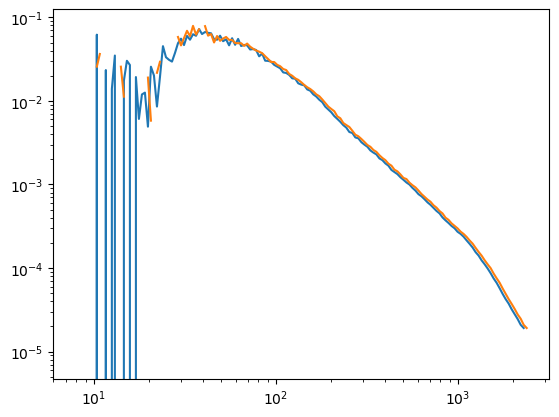

In [ ]:
fig, ax = plt.subplots()
ax.loglog(xe_p[:-1], h_ne_p)
ax.loglog(rbins_p, ne_prof)

In [ ]:
ne_summed = np.sum(h_ne_3D, axis=2)/nbins
ne2_summed = np.sum(h_ne_3D**2, axis=2)/nbins
Qne = np.sqrt(ne2_summed)/ne_summed
leff = r500/Qne**2

/tmp/ipykernel_1724599/1173080352.py:3: RuntimeWarning: divide by zero encountered in divide
  Qne = np.sqrt(ne2_summed)/ne_summed
/tmp/ipykernel_1724599/1173080352.py:3: RuntimeWarning: invalid value encountered in divide
  Qne = np.sqrt(ne2_summed)/ne_summed


In [ ]:
def centeredDistanceMatrix3D(n):
    # make sure n is odd
    x,y,z = np.meshgrid(range(n),range(n), range(n))
    return np.sqrt((x-(n/2)+1)**2+(y-(n/2)+1)**2+(z-(n/2)+1)**2)

In [ ]:
def beta_profile(r, n0, rc, b):
    return (n0**2)/(1+(r/rc)**2)**(3*b)

In [ ]:
not_nan = np.where(~np.isnan(ne_prof))[0][1:]

In [ ]:
popt, pcov = curve_fit(beta_profile, xe_p[not_nan], ne_prof[not_nan])
popt

/tmp/ipykernel_1724599/2052421356.py:2: RuntimeWarning: divide by zero encountered in divide
  return (n0**2)/(1+(r/rc)**2)**(3*b)
/tmp/ipykernel_1724599/2052421356.py:2: RuntimeWarning: overflow encountered in divide
  return (n0**2)/(1+(r/rc)**2)**(3*b)


array([2.17244357e-01, 9.48725378e+03, 1.21565170e+03])

Text(0.5, 1.0, '$\\Sigma \\, ne$')

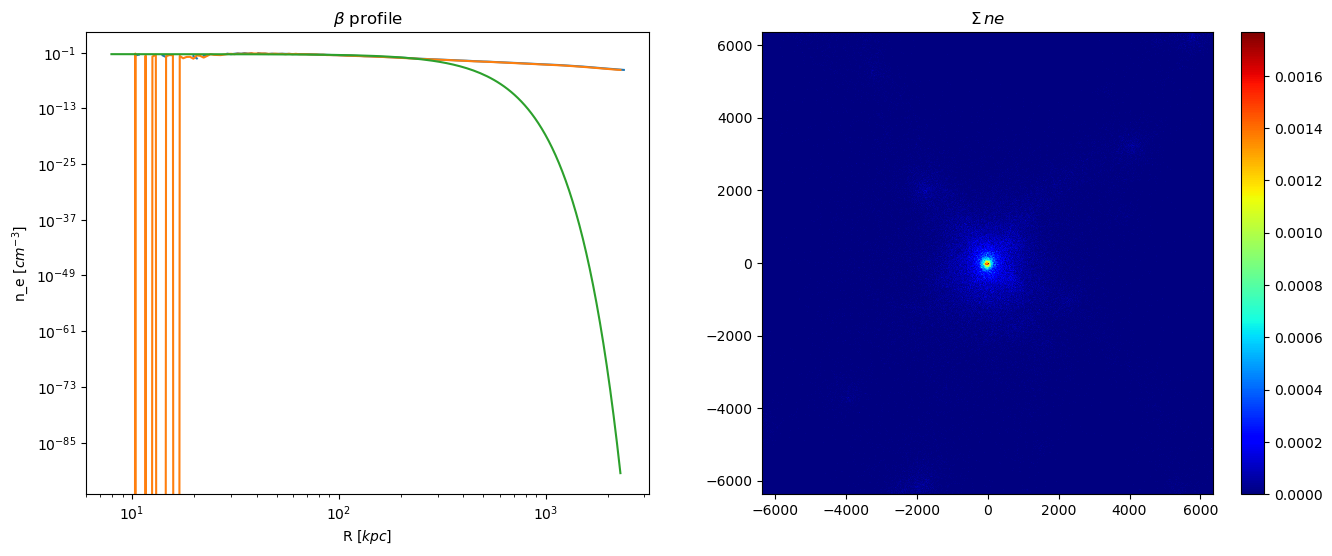

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].loglog(rbins_p, ne_prof)
ax[0].loglog(xe_p[:-1], h_ne_p)
ax[0].loglog(xe_p[:-1], beta_profile(xe_p[:-1], popt[0], popt[1], popt[2]))
ax[0].set_xlabel('R [$kpc$]')
ax[0].set_ylabel('n_e [$cm^{-3}$]')
ax[0].set_title('$\\beta$ profile')

ax[1].pcolor(xx, yy, ne_summed, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$\Sigma \, ne$')


Text(0.5, 1.0, '$\\Sigma \\, ne^2$')

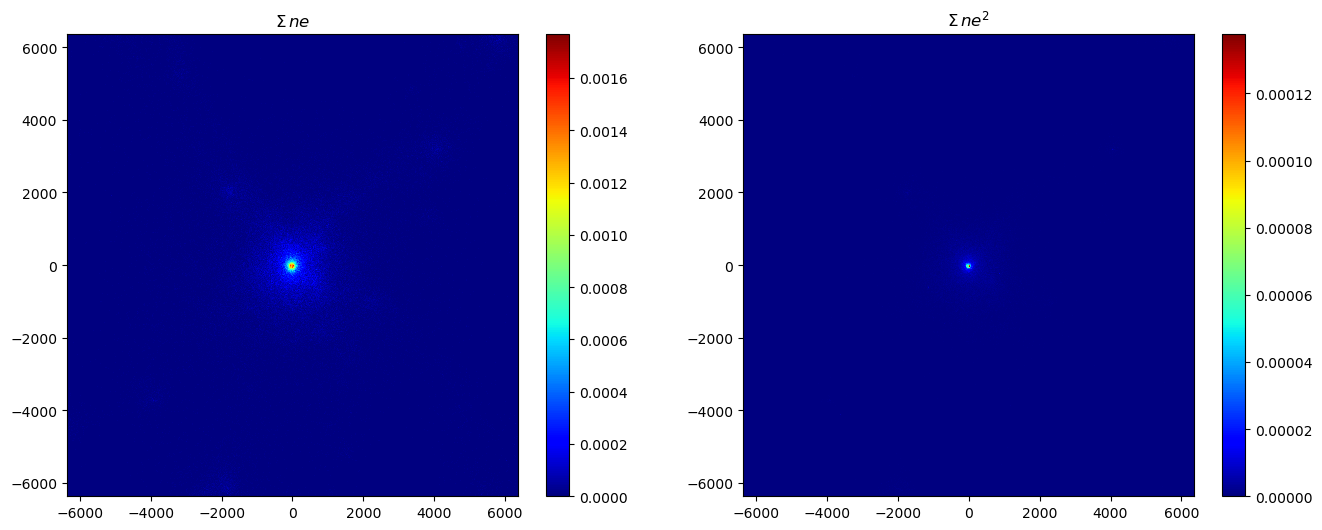

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, ne_summed, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$\Sigma \, ne$')

ax[1].pcolor(xx, yy, ne2_summed, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$\Sigma \, ne^2$')

/tmp/ipykernel_1724599/3100418046.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[0])
/tmp/ipykernel_1724599/3100418046.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[1])


Text(0.5, 1.0, '$l_{eff} = R_{500}/ Q_e^2$')

/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/matplotlib/colors.py:737: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/matplotlib/colors.py:738: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


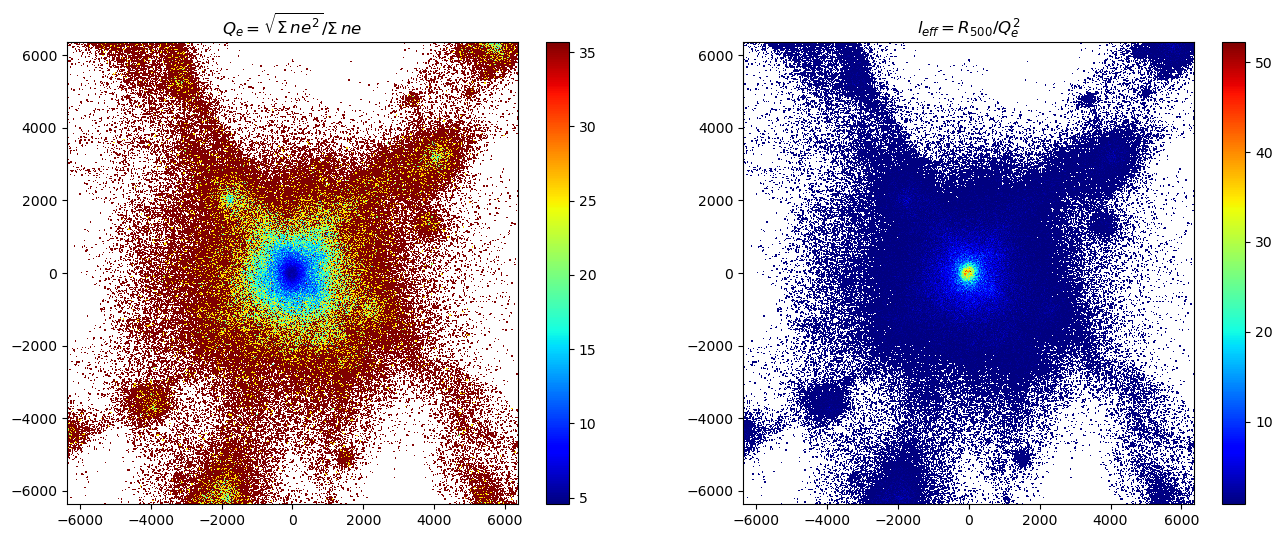

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, Qne, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$Q_e = \sqrt{\Sigma \, ne^2}/\Sigma \, ne$')

ax[1].pcolor(xx, yy, leff, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$l_{eff} = R_{500}/ Q_e^2$')

In [ ]:
ne_smoot = gaussian_filter(ne_summed, 4)
ne2_smoot = gaussian_filter(ne2_summed, 4)

Qne_smoot = np.sqrt(ne2_smoot)/ne_smoot
leff_smoot = r500/Qne_smoot**2

/tmp/ipykernel_1724599/3084823518.py:4: RuntimeWarning: divide by zero encountered in divide
  Qne_smoot = np.sqrt(ne2_smoot)/ne_smoot
/tmp/ipykernel_1724599/3084823518.py:4: RuntimeWarning: invalid value encountered in divide
  Qne_smoot = np.sqrt(ne2_smoot)/ne_smoot


Text(0.5, 1.0, '$\\Sigma \\, ne^2$')

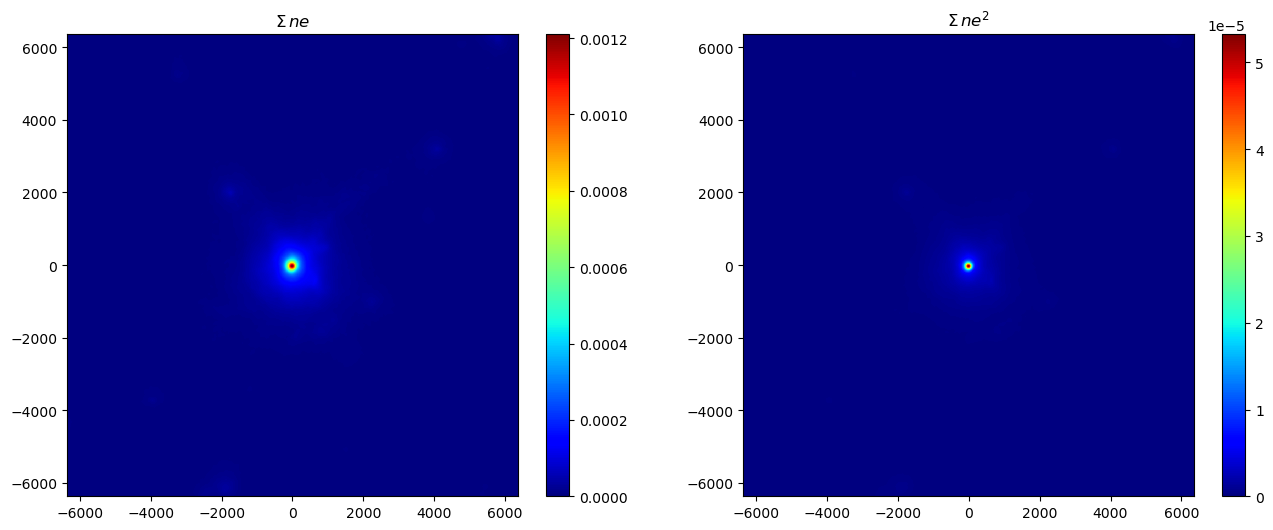

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, ne_smoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$\Sigma \, ne$')

ax[1].pcolor(xx, yy, ne2_smoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$\Sigma \, ne^2$')

/tmp/ipykernel_1724599/945585061.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[0])
/tmp/ipykernel_1724599/945585061.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[1])


Text(0.5, 1.0, '$l_{eff} = R_{500}/ Q_e^2$')

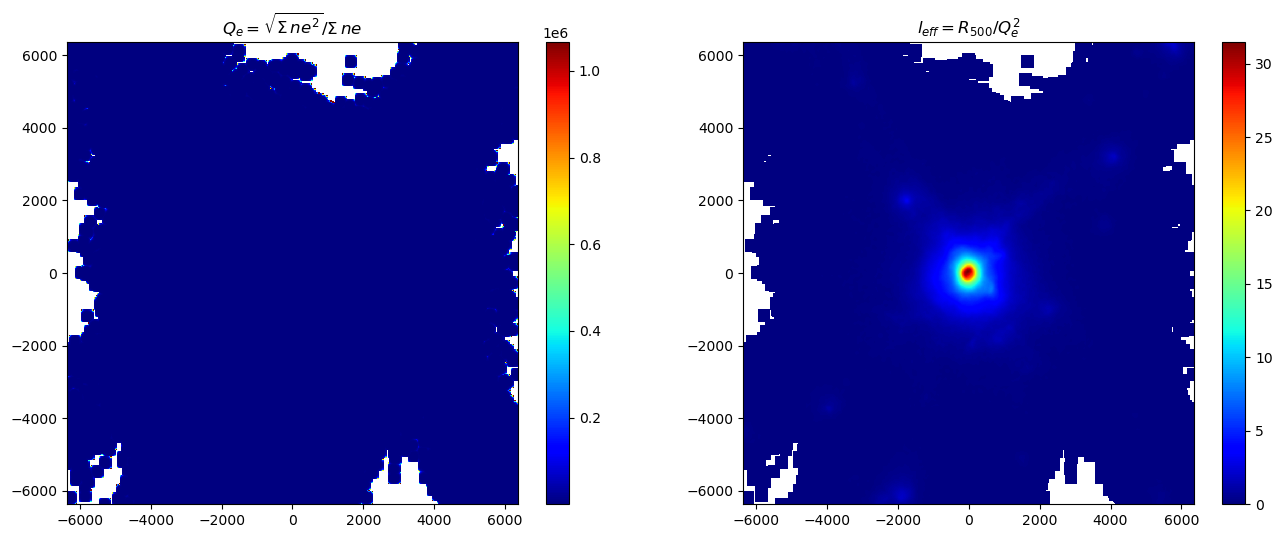

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, Qne_smoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$Q_e = \sqrt{\Sigma \, ne^2}/\Sigma \, ne$')

ax[1].pcolor(xx, yy, leff_smoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$l_{eff} = R_{500}/ Q_e^2$')

In [ ]:
ne_b_3D = beta_profile(centeredDistanceMatrix3D(nbins), popt[0], popt[1], popt[2])

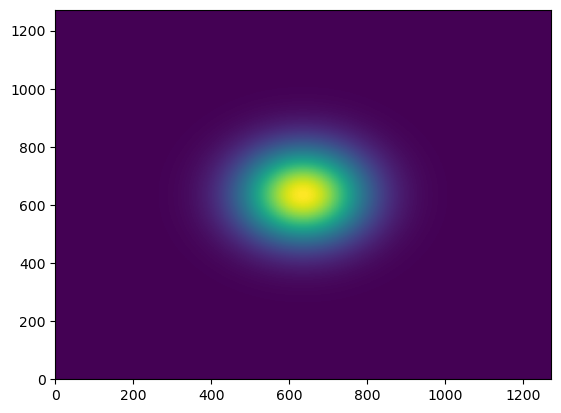

In [ ]:
plt.pcolormesh(ne_b_3D[0])

In [ ]:
ne_b = np.sum(ne_b_3D, axis=2)/nbins
ne2_b = np.sum(ne_b_3D**2, axis=2)/nbins
Qne_b = np.sqrt(ne2_b)/ne_b
leff_b = r500/Qne_b**2

Text(0.5, 1.0, '$\\Sigma \\, ne^2$')

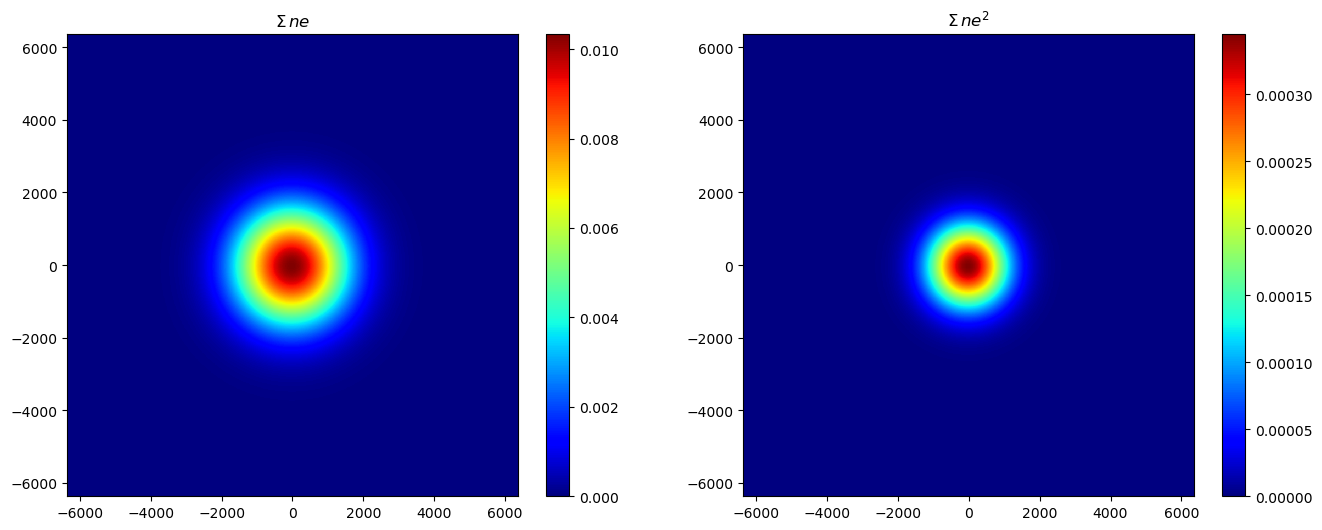

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, ne_b, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$\Sigma \, ne$')

ax[1].pcolor(xx, yy, ne2_b, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$\Sigma \, ne^2$')

Text(0.5, 1.0, '$l_{eff} = R_{500}/ Q_e^2$')

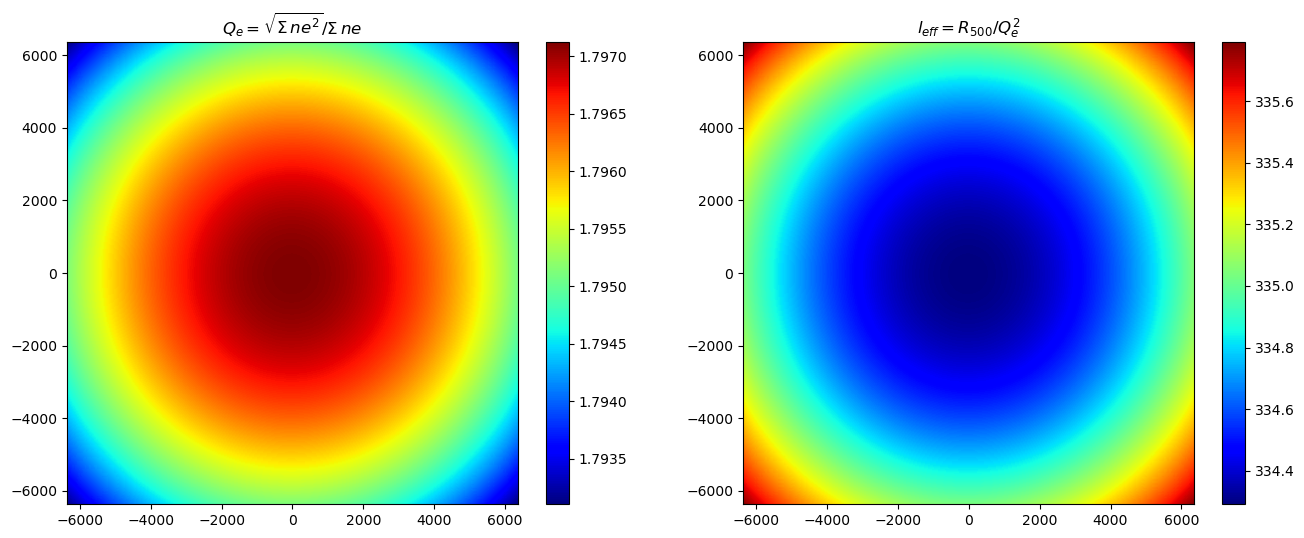

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, Qne_b, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$Q_e = \sqrt{\Sigma \, ne^2}/\Sigma \, ne$')

ax[1].pcolor(xx, yy, leff_b, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$l_{eff} = R_{500}/ Q_e^2$')

### Provo a fare uno smooting

In [ ]:
h_ne_3D_smoot = gaussian_filter(h_ne_3D, 3)

In [ ]:
ne_3Dsmoot = np.sum(h_ne_3D_smoot, axis=2)/nbins
ne2_3Dsmoot = np.sum(h_ne_3D_smoot**2, axis=2)/nbins

Qne_3Dsmoot = np.sqrt(ne2_3Dsmoot)/ne_3Dsmoot
leff_3Dsmoot = r500/Qne_3Dsmoot**2

leff_3Dsmoot_new_int = (2*r200_frac*r200)/Qne_3Dsmoot**2

/tmp/ipykernel_1724599/2157496515.py:4: RuntimeWarning: divide by zero encountered in divide
  Qne_3Dsmoot = np.sqrt(ne2_3Dsmoot)/ne_3Dsmoot
/tmp/ipykernel_1724599/2157496515.py:4: RuntimeWarning: invalid value encountered in divide
  Qne_3Dsmoot = np.sqrt(ne2_3Dsmoot)/ne_3Dsmoot


Text(0.5, 1.0, '$\\Sigma \\, ne^2$')

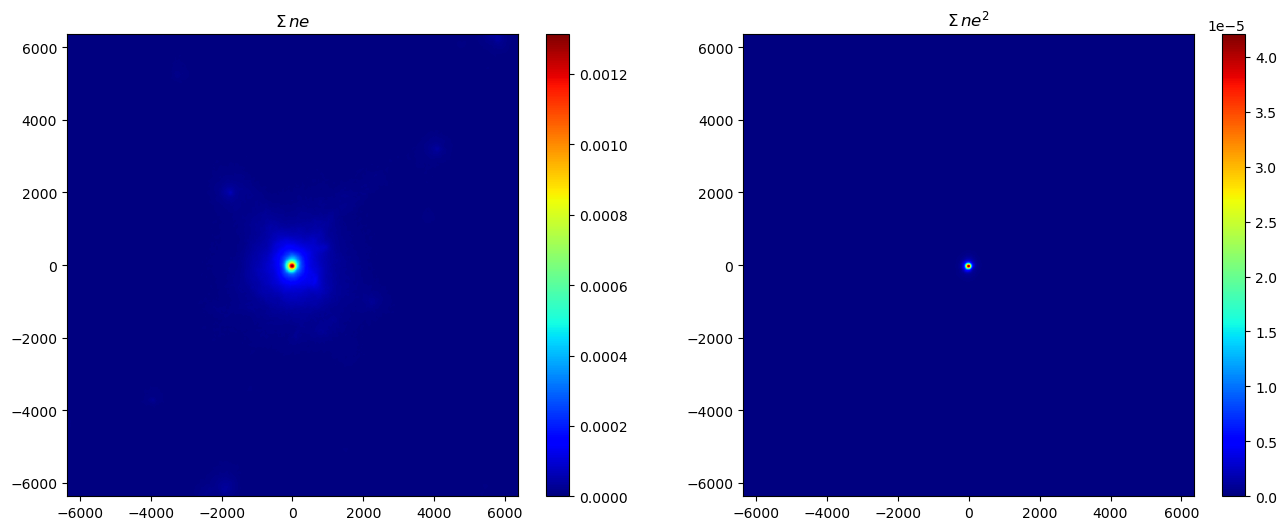

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, ne_3Dsmoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$\Sigma \, ne$')

ax[1].pcolor(xx, yy, ne2_3Dsmoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$\Sigma \, ne^2$')

/tmp/ipykernel_1724599/2480819032.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[0])
/tmp/ipykernel_1724599/2480819032.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[1])


Text(0.5, 1.0, '$l_{eff} = R_{500}/ Q_e^2$')

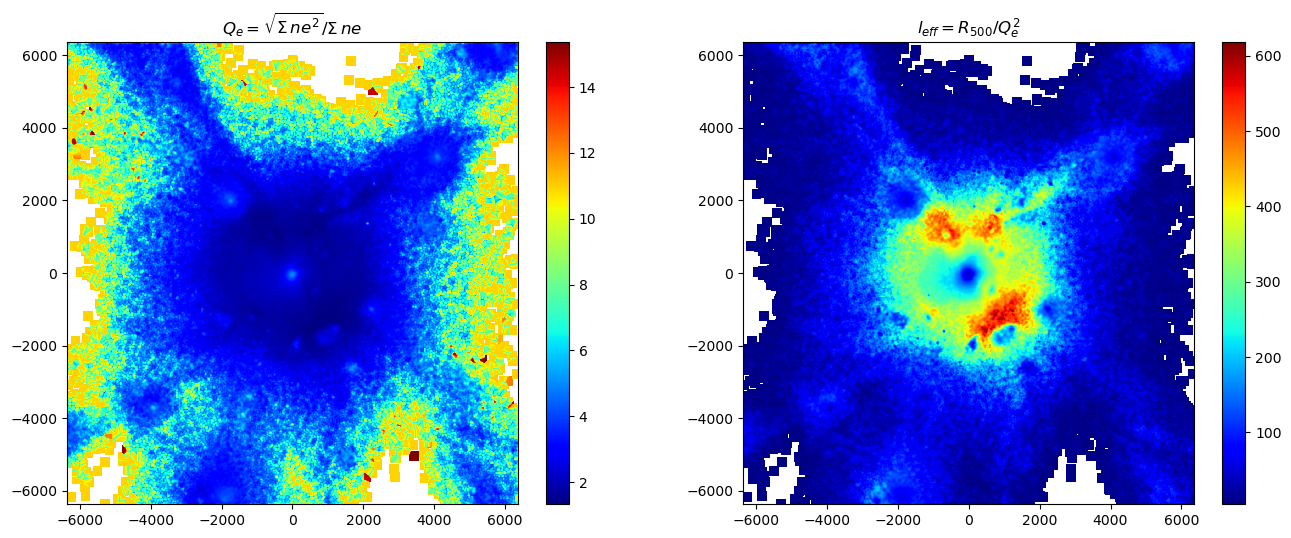

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, Qne_3Dsmoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$Q_e = \sqrt{\Sigma \, ne^2}/\Sigma \, ne$')

ax[1].pcolor(xx, yy, leff_3Dsmoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$l_{eff} = R_{500}/ Q_e^2$')

/tmp/ipykernel_1724599/1797187796.py:2: RuntimeWarning: divide by zero encountered in divide
  ax[0].pcolor(xx, yy, ne_3Dsmoot**2/ne2_3Dsmoot, cmap = "jet")
/tmp/ipykernel_1724599/1797187796.py:2: RuntimeWarning: invalid value encountered in divide
  ax[0].pcolor(xx, yy, ne_3Dsmoot**2/ne2_3Dsmoot, cmap = "jet")


/tmp/ipykernel_1724599/1797187796.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[0])
/tmp/ipykernel_1724599/1797187796.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[1])


Text(0.5, 1.0, '$l_{eff} = R_{500}/ Q_e^2$')

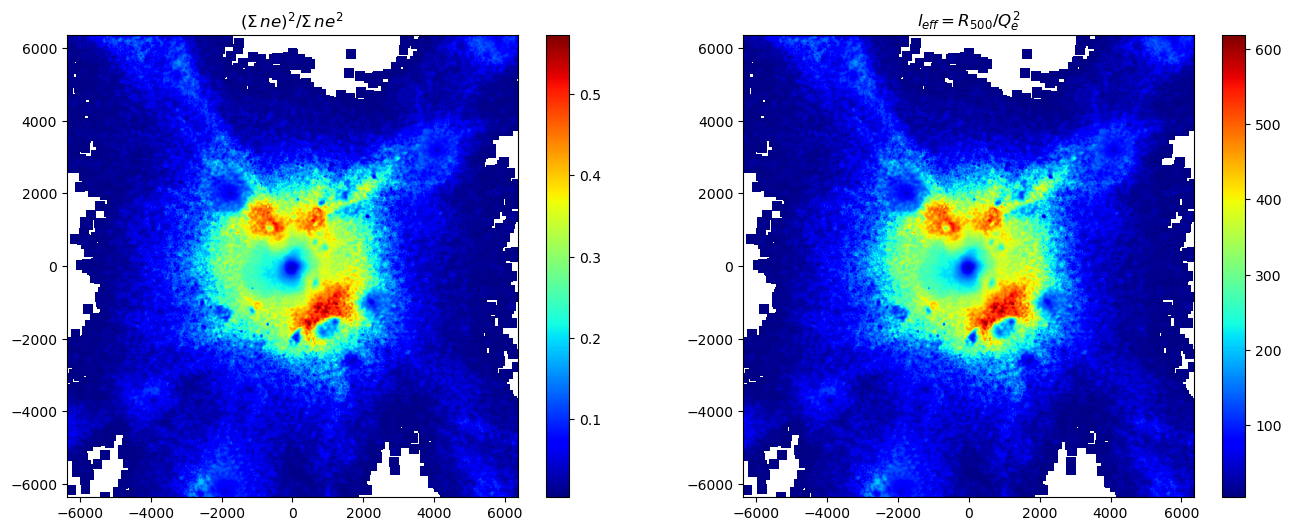

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, ne_3Dsmoot**2/ne2_3Dsmoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$(\Sigma \, ne)^2/\Sigma \, ne^2$')

ax[1].pcolor(xx, yy, leff_3Dsmoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$l_{eff} = R_{500}/ Q_e^2$')


In [ ]:
ne_3Dsmoot_smoot = gaussian_filter(ne_3Dsmoot, 8.807)
ne2_3Dsmoot_smoot = gaussian_filter(ne2_3Dsmoot, 8.807)

Qne_3Dsmoot_smoot = np.sqrt(ne2_3Dsmoot_smoot)/ne_3Dsmoot_smoot
leff_3Dsmoot_smoot = r500/Qne_3Dsmoot_smoot**2

/tmp/ipykernel_1724599/198721041.py:4: RuntimeWarning: divide by zero encountered in divide
  Qne_3Dsmoot_smoot = np.sqrt(ne2_3Dsmoot_smoot)/ne_3Dsmoot_smoot
/tmp/ipykernel_1724599/198721041.py:4: RuntimeWarning: invalid value encountered in divide
  Qne_3Dsmoot_smoot = np.sqrt(ne2_3Dsmoot_smoot)/ne_3Dsmoot_smoot


Text(0.5, 1.0, '$\\Sigma \\, ne^2$')

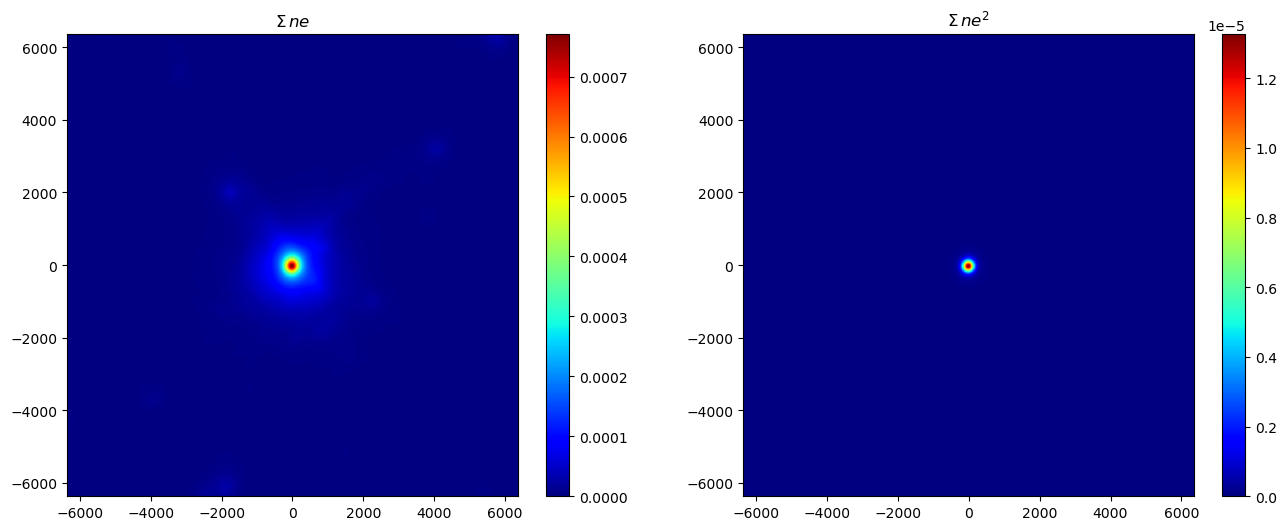

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, ne_3Dsmoot_smoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$\Sigma \, ne$')

ax[1].pcolor(xx, yy, ne2_3Dsmoot_smoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$\Sigma \, ne^2$')

/tmp/ipykernel_1724599/3914368487.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[0])
/tmp/ipykernel_1724599/3914368487.py:9: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pcm, ax=ax[1])


Text(0.5, 1.0, '$l_{eff} = R_{500}/ Q_e^2$')

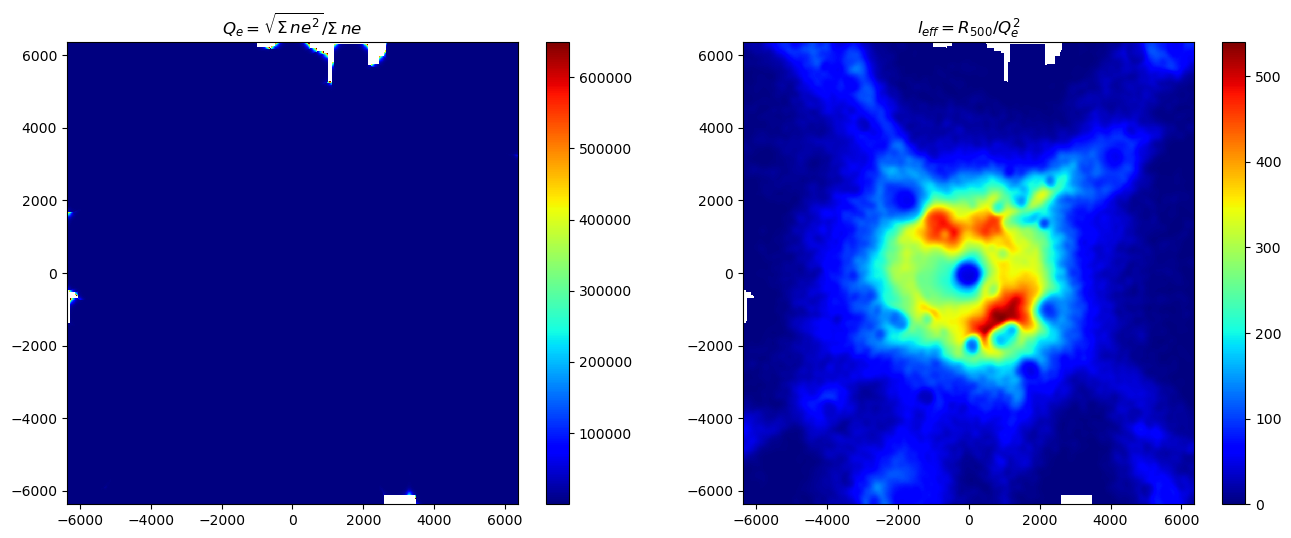

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 6)) 
ax[0].pcolor(xx, yy, Qne_3Dsmoot_smoot, cmap = "jet")
pcm = ax[0].get_children()[0]
plt.colorbar(pcm, ax=ax[0])
ax[0].set_title('$Q_e = \sqrt{\Sigma \, ne^2}/\Sigma \, ne$')

ax[1].pcolor(xx, yy, leff_3Dsmoot_smoot, cmap = "jet")
pcm = ax[1].get_children()[0]
plt.colorbar(pcm, ax=ax[1])
ax[1].set_title('$l_{eff} = R_{500}/ Q_e^2$')

In [153]:
ne_3D_hres = np.sum(h_ne_3D, axis=2)*bin_kp #/nbins
ne2_3D_hres = np.sum(h_ne_3D**2, axis=2)*bin_kp#/nbins

# Tests on the effect of the smooting on $l_{eff} = \frac{\left( \int n_e dl\right)^2}{\int n_e^2 dl}$

In [154]:
def Q_profile(cube, grid):
    nbin = 150
    rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(r200_frac*prop['r200']), num=nbin+1)

    xx, yy = np.meshgrid(grid[0][:-1], grid[1][:-1])
    dist = np.sqrt(xx**2 + yy**2)

    ne_3D_hres = np.sum(cube, axis=2)*bin_kp
    ne2_3D_hres = np.sum(cube**2, axis=2)*bin_kp

    Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)

    Q_prof = []
    Q_low_err = []
    Q_up_err = []

    Q_prof.append(np.nanmean(Q_map[(dist<=rr[0])]))
    Q_low_err.append(np.nanpercentile(Q_map[(dist<=rr[0])], 31.73))
    Q_up_err.append(np.nanpercentile(Q_map[(dist<=rr[0])], 68.27))

    for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
        Q_prof = np.append(Q_prof, np.nanmean(Q_map[(dist>rr0) & (dist<=rr1)]))
        Q_low_err = np.append(Q_low_err, np.nanpercentile(Q_map[(dist>rr0) & (dist<=rr1)], 31.73))
        Q_up_err = np.append(Q_up_err, np.nanpercentile(Q_map[(dist>rr0) & (dist<=rr1)], 68.27))
    return Q_prof, Q_low_err, Q_up_err, rbins_p

In [155]:
r500

1079.6435089526487

In [156]:
cosm.kpc_proper_per_arcmin(0.592).value

410.57846661339755

In [157]:
leff_test_map = (np.sum(gaussian_filter(h_ne_3D,3), axis=2)*bin_kp)**2/(np.sum(gaussian_filter(h_ne_3D,3)**2, axis=2)*bin_kp) #
psize = 2*r200_frac*r200/len(leff_test_map)
r500_pix = r500/psize
r200_pix = r200/psize

print(psize)

distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(leff_test_map)*psize//2, len(leff_test_map)*psize//2, len(leff_test_map)), 
                                               np.linspace(-len(leff_test_map)*psize//2, len(leff_test_map)*psize//2, len(leff_test_map)))

arcmin_grid_x = distance_grid_x / cosm.kpc_proper_per_arcmin(0.592).value
arcmin_grid_y = distance_grid_y / cosm.kpc_proper_per_arcmin(0.592).value
r500_arcmin = r500/cosm.kpc_proper_per_arcmin(0.592).value
r200_arcmin = r200/cosm.kpc_proper_per_arcmin(0.592).value

/tmp/ipykernel_3757475/1212988218.py:1: RuntimeWarning: divide by zero encountered in divide
  leff_test_map = (np.sum(gaussian_filter(h_ne_3D,3), axis=2)*bin_kp)**2/(np.sum(gaussian_filter(h_ne_3D,3)**2, axis=2)*bin_kp) #
/tmp/ipykernel_3757475/1212988218.py:1: RuntimeWarning: invalid value encountered in divide
  leff_test_map = (np.sum(gaussian_filter(h_ne_3D,3), axis=2)*bin_kp)**2/(np.sum(gaussian_filter(h_ne_3D,3)**2, axis=2)*bin_kp) #


In [158]:
grid_to_pick_x = distance_grid_x #arcmin_grid_x
grid_to_pick_y = distance_grid_y #arcmin_grid_y
r500_to_pick = r500 #r500_arcmin
r200_to_pick = r200 #r200_arcmin
radius_1arcmin = cosm.kpc_proper_per_arcmin(0.592).value #1

print(radius_1arcmin)

410.57846661339755


NameError: name 'leff_3Dsmoot_new_int' is not defined

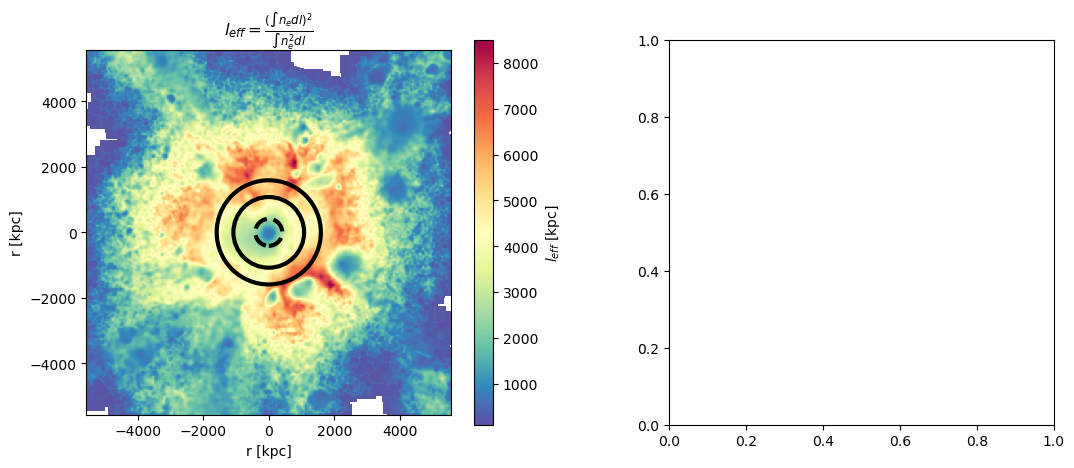

In [159]:
fig =plt.figure(figsize=(20, 5))
ax1=fig.add_subplot(131, aspect='equal')
test_leffmap = plt.pcolormesh(grid_to_pick_x, grid_to_pick_y, leff_test_map, cmap='Spectral_r')
circle_R500 = plt.Circle((0., 0.),
                        r500_to_pick, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.),
                        r200_to_pick, color='k', fill=False, lw=3)
circle_1arcmin = plt.Circle((0., 0.),
                        radius_1arcmin, color='k', fill=False, lw=3, ls='--')
ax1.add_artist(circle_R200)
ax1.add_artist(circle_R500)
ax1.add_artist(circle_1arcmin)
ax1.set_title(r'$l_{eff} = \frac{(\int n_e dl)^2}{\int n_e^2 dl}$')
if grid_to_pick_x.all() == distance_grid_x.all():
    ax1.set_xlabel('r [kpc]')
    ax1.set_ylabel('r [kpc]')
else :
    ax1.set_xlabel(r'$\theta$ [arcmin]')
    ax1.set_ylabel(r'$\theta$ [arcmin]')
plt.colorbar(test_leffmap, label = '$l_{eff}$ [kpc]')

ax2=fig.add_subplot(132, aspect='equal')
test_leffmap_Qdef = plt.pcolormesh(grid_to_pick_x, grid_to_pick_y, leff_3Dsmoot_new_int, cmap='Spectral_r')
circle_R500 = plt.Circle((0., 0.),
                        r500_to_pick, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.),
                        r200_to_pick, color='k', fill=False, lw=3)
circle_1arcmin = plt.Circle((0., 0.),
                        radius_1arcmin, color='k', fill=False, lw=3, ls='--')
ax2.add_artist(circle_R200)
ax2.add_artist(circle_R500)
ax2.add_artist(circle_1arcmin)
ax2.set_title('$l_{eff} = $'+f'${2*r200_frac}$'+'$R_{200}/Q^2$')
if grid_to_pick_x.all() == distance_grid_x.all():
    ax2.set_xlabel('r [kpc]')
    ax2.set_ylabel('r [kpc]')
else :
    ax2.set_xlabel(r'$\theta$ [arcmin]')
    ax2.set_ylabel(r'$\theta$ [arcmin]')
plt.colorbar(test_leffmap_Qdef, label = '$l_{eff}$ [kpc]')

ax3=fig.add_subplot(133, aspect='equal')
leff_defs_comp = plt.pcolormesh(grid_to_pick_x, grid_to_pick_y, (leff_test_map-leff_3Dsmoot_new_int)/leff_test_map, cmap='Spectral_r')
circle_R500 = plt.Circle((0., 0.),
                        r500_to_pick, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.),
                        r200_to_pick, color='k', fill=False, lw=3)
circle_1arcmin = plt.Circle((0., 0.),
                        radius_1arcmin, color='k', fill=False, lw=3, ls='--')
ax3.add_artist(circle_R200)
ax3.add_artist(circle_R500)
ax3.add_artist(circle_1arcmin)
ax3.set_title('$(l_{eff, int}-l_{eff, Q})/l_{eff, int}$')
if grid_to_pick_x.all() == distance_grid_x.all():
    ax3.set_xlabel('r [kpc]')
    ax3.set_ylabel('r [kpc]')
else :
    ax3.set_xlabel(r'$\theta$ [arcmin]')
    ax3.set_ylabel(r'$\theta$ [arcmin]')
plt.colorbar(leff_defs_comp)

if grid_to_pick_x.all() == distance_grid_x.all():
    inf_type = 'distance'
else:
    inf_type = 'arcmin'
plt.subplots_adjust(right=0.95, left=0.05)
plt.savefig(f'leff_definitions_comparison_{inf_type}_{2*r200_frac}r200.jpg')

/tmp/ipykernel_1724599/3805392667.py:11: RuntimeWarning: divide by zero encountered in divide
  Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)
/tmp/ipykernel_1724599/3805392667.py:11: RuntimeWarning: invalid value encountered in divide
  Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)
/tmp/ipykernel_1724599/3805392667.py:22: RuntimeWarning: Mean of empty slice
  Q_prof = np.append(Q_prof, np.nanmean(Q_map[(dist>rr0) & (dist<=rr1)]))
/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


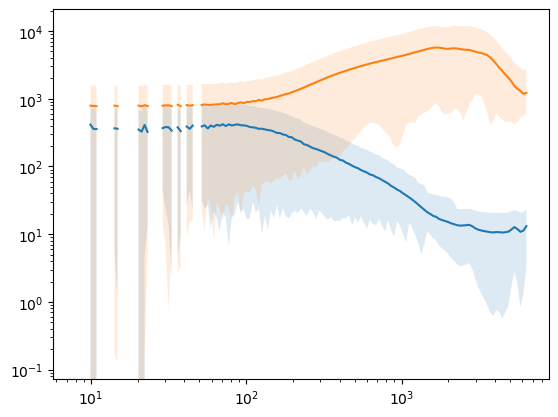

In [84]:
Q_slice_hres, Q_slice_lowerr, Q_slice_uperr, radii = Q_profile(h_ne_3D, x_ne_grid)
Q_slice_1_5pix, Q_slice_lowerr_15pix, Q_slice_uperr_15pix, radii = Q_profile(gaussian_filter(h_ne_3D,8), x_ne_grid)
plt.loglog(radii, Q_slice_hres)
plt.loglog(radii, Q_slice_1_5pix)
plt.fill_between(radii, Q_slice_hres - Q_slice_lowerr, Q_slice_hres+Q_slice_uperr, alpha=0.15)
plt.fill_between(radii, Q_slice_1_5pix - Q_slice_lowerr_15pix, Q_slice_1_5pix + Q_slice_uperr_15pix, alpha=0.15)

In [85]:
visualisation_grid = np.ones((30, len(radii)))
smoothing_radii = np.logspace(-2, 1, 30)

for i, radius in enumerate(smoothing_radii):
    print(radius)
    line, sigma_down, sigma_up, radii= Q_profile(gaussian_filter(h_ne_3D, radius), x_ne_grid)
    visualisation_grid[i] *= line

0.01


/tmp/ipykernel_1724599/3805392667.py:11: RuntimeWarning: divide by zero encountered in divide
  Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)
/tmp/ipykernel_1724599/3805392667.py:11: RuntimeWarning: invalid value encountered in divide
  Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)
/tmp/ipykernel_1724599/3805392667.py:22: RuntimeWarning: Mean of empty slice
  Q_prof = np.append(Q_prof, np.nanmean(Q_map[(dist>rr0) & (dist<=rr1)]))


0.01268961003167922
0.01610262027560939
0.020433597178569417
0.02592943797404667
0.03290344562312668
0.041753189365604
0.05298316906283707
0.06723357536499334
0.08531678524172806
0.10826367338740546
0.1373823795883263
0.17433288221999882
0.2212216291070449
0.2807216203941177
0.3562247890262442
0.4520353656360243
0.5736152510448679
0.727895384398315
0.9236708571873861
1.1721022975334805
1.4873521072935119
1.8873918221350976
2.395026619987486
3.039195382313198
3.856620421163472
4.893900918477494
6.2101694189156165
7.880462815669913
10.0


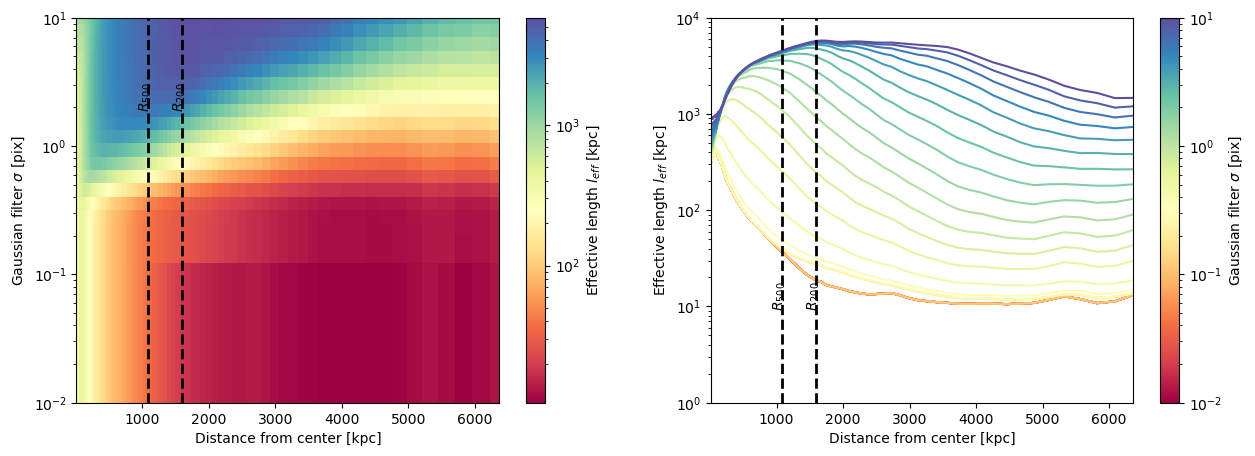

In [86]:
from matplotlib import colors
from matplotlib import cm

c_norm = colors.LogNorm(vmin=np.min(smoothing_radii), vmax=np.max(smoothing_radii))

# Pick a colormap
c_map  = cm.Spectral

# Scalar mappable of normalized array to colormap
s_map  = cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121)
Qmap = ax1.pcolormesh(radii, smoothing_radii, visualisation_grid, cmap='Spectral', norm=colors.LogNorm())#vmin=0.8, vmax=30
ax1.set_yscale('log')
ax1.set_ylabel('Gaussian filter $\sigma$ [pix]')
ax1.set_xlabel('Distance from center [kpc]')
ax1.vlines([r500, r200], smoothing_radii.min(), smoothing_radii.max(), colors='k', ls='--', lw=2)
ax1.set_xlim(radii.min(), radii.max())
ax1.set_ylim(smoothing_radii.min(), smoothing_radii.max())
ax1.text(r500-150, 2, '$R_{500}$', rotation='vertical')
ax1.text(r200-150, 2, '$R_{200}$', rotation='vertical')
plt.colorbar(Qmap, label='Effective length $l_{eff}$ [kpc]')

ax2 = fig.add_subplot(122)
for i, radius in enumerate(smoothing_radii):
    ax2.plot(radii, visualisation_grid[i], label = f'$\sigma = {radius:.4f}$ pix', color=s_map.to_rgba(radius))
ax2.set_yscale('log')
ax2.set_ylabel('Effective length $l_{eff}$ [kpc]')
ax2.set_xlabel('Distance from center [kpc]')
ax2.set_xlim(radii.min(), radii.max())
ax2.set_ylim(1., 1e4)
ax2.vlines([r500, r200], 1., 1e4, colors='k', ls='--', lw=2)
ax2.text(r500-150, 10, '$R_{500}$', rotation='vertical')
ax2.text(r200-150, 10, '$R_{200}$', rotation='vertical')
plt.colorbar(s_map, label='Gaussian filter $\sigma$ [pix]', ax=ax2)

plt.savefig(f'{plot_dir}/Smoothing_test_leff.jpg')


# Test for degrading the maps, pixel size of $\geq$ 20kpc

In [87]:
nbins_20kpc = int(prop['r200']*r200_frac/50)*2
rbins_20kpc = np.linspace(-prop['r200']*r200_frac, prop['r200']*r200_frac, num=nbins_20kpc+1)

psize_20kpc = np.abs(rbins_20kpc[0]-rbins_20kpc[1])

bin_kp_20kpc = np.abs((rbins_20kpc [0]-rbins_20kpc[1]))#*prop['r200'])
bin_cm_20kpc = bin_kp_20kpc*const.kpc.to('cm').value #unit: (cm/h)^3	

vol_20kpc = bin_kp_20kpc**3  #unit: (kpc/h)^3
volcm_20kpc = vol_20kpc*const.kpc.to('cm').value**3 #unit: (cm/h)^3

In [88]:
h_ne_grid_20kpc, x_ne_grid_20kpc = np.histogramdd([x,y,z], bins=(nbins_20kpc, nbins_20kpc, nbins_20kpc), weights=np.float64(ne)/m_ptoMsun/0.6777 )
h_ne_grid_20kpc = h_ne_grid_20kpc.transpose()
h_ne_3D_20kpc = h_ne_grid_20kpc/bin_cm_20kpc**3

In [89]:
ne_20kpc = np.sum(h_ne_3D_20kpc, axis=2)*bin_kp_20kpc #/nbins_20kpc
ne2_20kpc = np.sum(h_ne_3D_20kpc**2, axis=2)*bin_kp_20kpc#/nbins_20kpc

In [90]:
print(ne_20kpc.shape)

(254, 254)


/tmp/ipykernel_1724599/3990847645.py:1: RuntimeWarning: divide by zero encountered in divide
  map_20kpc = plt.pcolormesh(ne_20kpc**2/ne2_20kpc, norm=colors.LogNorm(), cmap='Spectral_r')
/tmp/ipykernel_1724599/3990847645.py:1: RuntimeWarning: invalid value encountered in divide
  map_20kpc = plt.pcolormesh(ne_20kpc**2/ne2_20kpc, norm=colors.LogNorm(), cmap='Spectral_r')


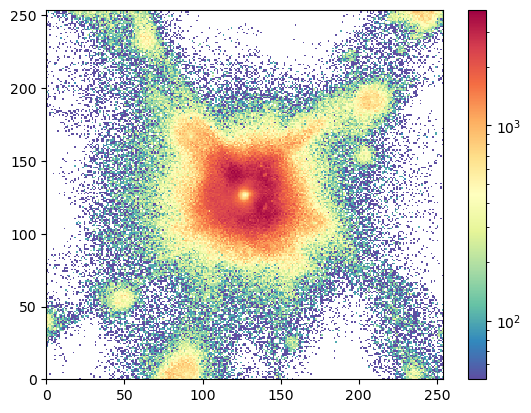

In [91]:
map_20kpc = plt.pcolormesh(ne_20kpc**2/ne2_20kpc, norm=colors.LogNorm(), cmap='Spectral_r')
plt.colorbar(map_20kpc)

In [92]:
visualisation_grid_20kpc = np.ones((30, len(radii)))
smoothing_radii = np.logspace(-2, 1, 30)

for i, radius in enumerate(smoothing_radii):
    print(radius)
    line, sigma_down, sigma_up, radii= Q_profile(gaussian_filter(h_ne_3D_20kpc, radius), x_ne_grid_20kpc)
    visualisation_grid_20kpc[i] *= line


#visualisation_grid_20kpc = np.ones((30, len(h_ne_3D_20kpc)//2))
#smoothing_radii = np.logspace(-2, 1, 30)
#dist_from_center_20kpc = 40*np.linspace(0, len(h_ne_3D_20kpc)//2-1, len(h_ne_3D_20kpc)//2)

#for i, radius in enumerate(smoothing_radii):
#    print(radius)
#    visualisation_grid_20kpc[i] *= Q_profile(gaussian_filter(h_ne_3D_20kpc, radius))

0.01


/tmp/ipykernel_1724599/3805392667.py:11: RuntimeWarning: divide by zero encountered in divide
  Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)
/tmp/ipykernel_1724599/3805392667.py:11: RuntimeWarning: invalid value encountered in divide
  Q_map = np.divide(ne_3D_hres**2, ne2_3D_hres)
/tmp/ipykernel_1724599/3805392667.py:22: RuntimeWarning: Mean of empty slice
  Q_prof = np.append(Q_prof, np.nanmean(Q_map[(dist>rr0) & (dist<=rr1)]))
/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.01268961003167922


0.01610262027560939
0.020433597178569417
0.02592943797404667
0.03290344562312668
0.041753189365604
0.05298316906283707
0.06723357536499334
0.08531678524172806
0.10826367338740546
0.1373823795883263
0.17433288221999882
0.2212216291070449
0.2807216203941177
0.3562247890262442
0.4520353656360243
0.5736152510448679
0.727895384398315
0.9236708571873861
1.1721022975334805
1.4873521072935119
1.8873918221350976
2.395026619987486
3.039195382313198
3.856620421163472
4.893900918477494
6.2101694189156165
7.880462815669913
10.0


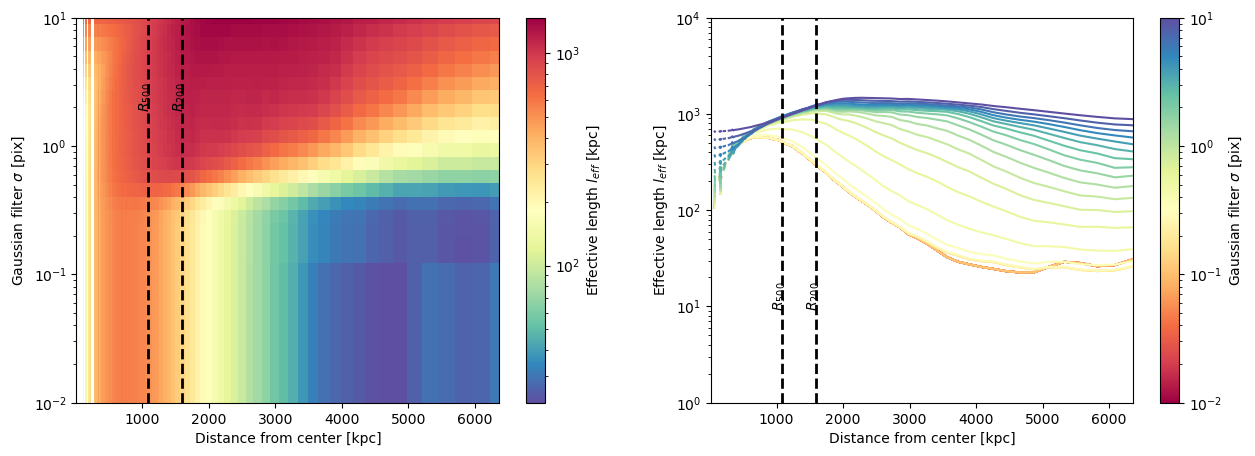

In [93]:
c_norm = colors.LogNorm(vmin=np.min(smoothing_radii), vmax=np.max(smoothing_radii))

# Pick a colormap
c_map  = cm.Spectral

# Scalar mappable of normalized array to colormap
s_map  = cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121)
Qmap = ax1.pcolormesh(radii, smoothing_radii, visualisation_grid_20kpc, cmap='Spectral_r', norm=colors.LogNorm()) #vmin=0.8, vmax=30
ax1.set_yscale('log')
ax1.set_ylabel('Gaussian filter $\sigma$ [pix]')
ax1.set_xlabel('Distance from center [kpc]')
ax1.vlines([r500, r200], smoothing_radii.min(), smoothing_radii.max(), colors='k', ls='--', lw=2)
ax1.set_xlim(radii.min(), radii.max())
ax1.set_ylim(smoothing_radii.min(), smoothing_radii.max())
ax1.text(r500-150, 2, '$R_{500}$', rotation='vertical')
ax1.text(r200-150, 2, '$R_{200}$', rotation='vertical')
plt.colorbar(Qmap, label='Effective length $l_{eff}$ [kpc]')

ax2 = fig.add_subplot(122)
for i, radius in enumerate(smoothing_radii):
    ax2.plot(radii, visualisation_grid_20kpc[i], label = f'$\sigma = {radius:.4f}$ pix', color=s_map.to_rgba(radius))
ax2.set_yscale('log')
ax2.set_ylabel('Effective length $l_{eff}$ [kpc]')
ax2.set_xlabel('Distance from center [kpc]')
ax2.set_xlim(radii.min(), radii.max())
ax2.set_ylim(1., 1e4)
ax2.vlines([r500, r200], 1., 1e4, colors='k', ls='--', lw=2)
ax2.text(r500-150, 10, '$R_{500}$', rotation='vertical')
ax2.text(r200-150, 10, '$R_{200}$', rotation='vertical')
plt.colorbar(s_map, label='Gaussian filter $\sigma$ [pix]', ax=ax2)

plt.savefig(f'{plot_dir}/Smoothing_test_leff_50kpc.jpg')

# Different tests on $l_{eff}$

## Using the $n_e$ and $n_e^2$ numerical profiles

In [94]:
h_ne_3D_smoothed = gaussian_filter(h_ne_3D, 3)

cube_to_use = h_ne_3D_smoothed

nbin = 250
rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(1.5*prop['r200']), num=nbin+1)

xxx, yyy, zzz = np.meshgrid(x_ne_grid[0][:-1], x_ne_grid[1][:-1], x_ne_grid[2][:-1])

dist = np.sqrt(xxx**2 + yyy**2 + zzz**2)

h_ne2_3D = cube_to_use**2

ne_prof = []
ne_prof.append(np.nanmean(cube_to_use[(dist<=rr[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    ne_prof = np.append(ne_prof, np.nanmean(cube_to_use[(dist>rr0) & (dist<=rr1)]))

ne2_prof = []
ne2_prof.append(np.nanmean(h_ne2_3D[(dist<=rr[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    ne2_prof = np.append(ne2_prof, np.nanmean(h_ne2_3D[(dist>rr0) & (dist<=rr1)]))

not_nan_ne = np.where(~np.isnan(ne_prof))[0][1:]

ne_prof = ne_prof[not_nan_ne]
ne2_prof = ne2_prof[not_nan_ne]
rbins_p = rbins_p[not_nan_ne]

/tmp/ipykernel_1724599/452890148.py:17: RuntimeWarning: Mean of empty slice
  ne_prof = np.append(ne_prof, np.nanmean(cube_to_use[(dist>rr0) & (dist<=rr1)]))
/tmp/ipykernel_1724599/452890148.py:22: RuntimeWarning: Mean of empty slice
  ne2_prof = np.append(ne2_prof, np.nanmean(h_ne2_3D[(dist>rr0) & (dist<=rr1)]))


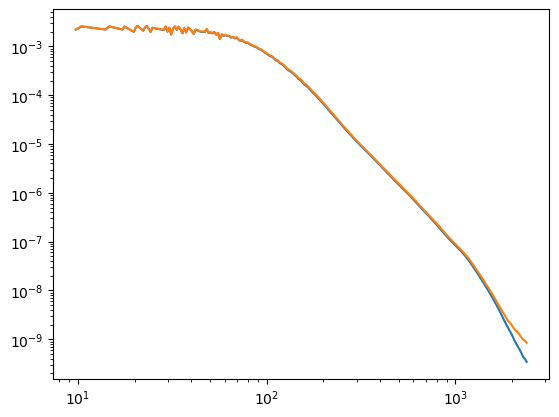

In [95]:
plt.loglog(rbins_p, ne_prof**2)
plt.loglog(rbins_p, ne2_prof)

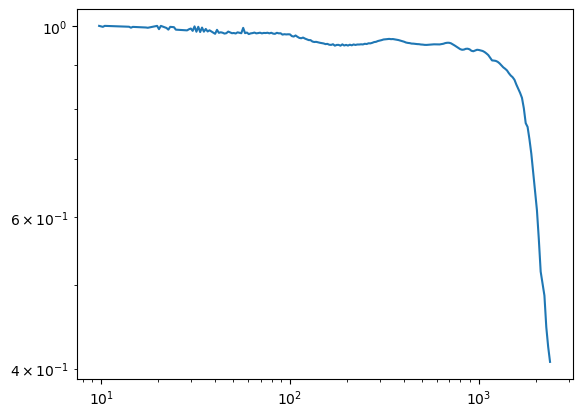

In [96]:
plt.loglog(rbins_p, ne_prof**2/ne2_prof)

In [97]:
ne_grid_to_fill = centeredDistanceMatrix3D(len(ne_prof))
ne2_grid_to_fill = centeredDistanceMatrix3D(len(ne2_prof))
for i in range(len(ne_grid_to_fill)):
    for j in range(len(ne_grid_to_fill[i])) :
        for k in range(len(ne_grid_to_fill[i][j])) :
            ne_grid_to_fill[i][j][k] = ne_prof[round(ne_grid_to_fill[i][j][k])]
            ne2_grid_to_fill[i][j][k] = ne2_prof[round(ne2_grid_to_fill[i][j][k])]
            
print(ne_grid_to_fill)

[[[0.00017887 0.00017887 0.00019099 ... 0.00017887 0.00017887 0.00016758]
  [0.00017887 0.00019099 0.00020317 ... 0.00019099 0.00017887 0.00017887]
  [0.00019099 0.00020317 0.00020317 ... 0.00020317 0.00019099 0.00017887]
  ...
  [0.00017887 0.00019099 0.00020317 ... 0.00019099 0.00017887 0.00017887]
  [0.00017887 0.00017887 0.00019099 ... 0.00017887 0.00017887 0.00016758]
  [0.00016758 0.00017887 0.00017887 ... 0.00017887 0.00016758 0.00016758]]

 [[0.00017887 0.00019099 0.00020317 ... 0.00019099 0.00017887 0.00017887]
  [0.00019099 0.00020317 0.00020317 ... 0.00020317 0.00019099 0.00017887]
  [0.00020317 0.00020317 0.00021519 ... 0.00020317 0.00020317 0.00019099]
  ...
  [0.00019099 0.00020317 0.00020317 ... 0.00020317 0.00019099 0.00017887]
  [0.00017887 0.00019099 0.00020317 ... 0.00019099 0.00017887 0.00017887]
  [0.00017887 0.00017887 0.00019099 ... 0.00017887 0.00017887 0.00016758]]

 [[0.00019099 0.00020317 0.00020317 ... 0.00020317 0.00019099 0.00017887]
  [0.00020317 0.000203

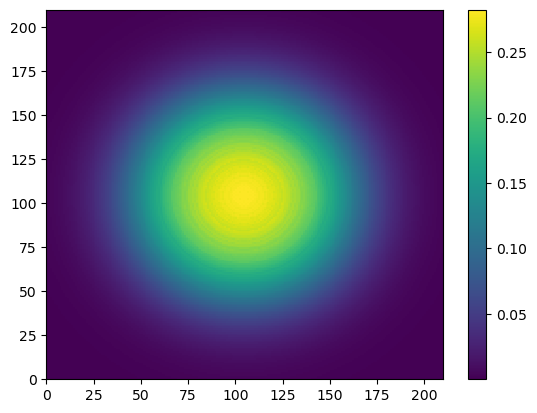

In [98]:
cmap = plt.pcolormesh(np.sum(ne2_grid_to_fill, axis=2))
plt.colorbar(cmap)

[[1929.530806   1927.65219769 1929.31284752 ... 1927.65219769
  1929.530806   1931.0075609 ]
 [1927.65219769 1929.31284752 1924.77127831 ... 1929.31284752
  1927.65219769 1929.530806  ]
 [1929.31284752 1924.77127831 1925.21775656 ... 1924.77127831
  1929.31284752 1928.82761064]
 ...
 [1927.65219769 1929.31284752 1924.77127831 ... 1929.31284752
  1927.65219769 1929.530806  ]
 [1929.530806   1927.65219769 1929.31284752 ... 1927.65219769
  1929.530806   1931.0075609 ]
 [1931.0075609  1929.530806   1928.82761064 ... 1929.530806
  1931.0075609  1933.52398228]]


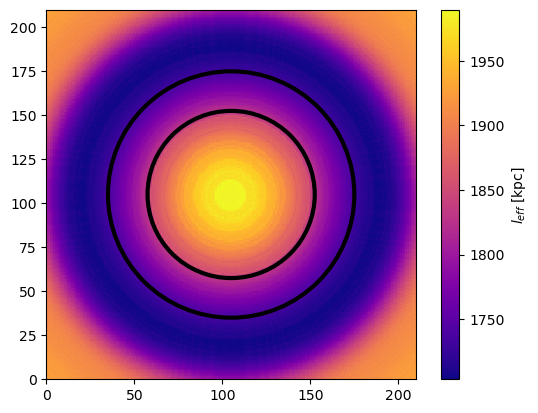

In [99]:
leff_numerical_map = (np.nansum(ne_grid_to_fill, axis=2)*(1.5*r200/len(ne_grid_to_fill)))**2/(np.nansum(ne2_grid_to_fill, axis=2)*(1.5*r200/len(ne_grid_to_fill)))
print(leff_numerical_map)

psize = 3*r200/len(leff_numerical_map)
r500_pix = r500/psize
r200_pix = r200/psize

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
leffmap=ax.pcolormesh(leff_numerical_map, cmap='plasma')
circle_R500 = plt.Circle((len(leff_numerical_map) // 2, len(leff_numerical_map) // 2),
                        r500_pix, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((len(leff_numerical_map) // 2, len(leff_numerical_map) // 2),
                        r200_pix, color='k', fill=False, lw=3)
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
plt.colorbar(leffmap, label='$l_{eff}$ [kpc]')

plt.savefig(f'{plot_dir}/leff_map_numerical_densityprofile.jpg')

/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


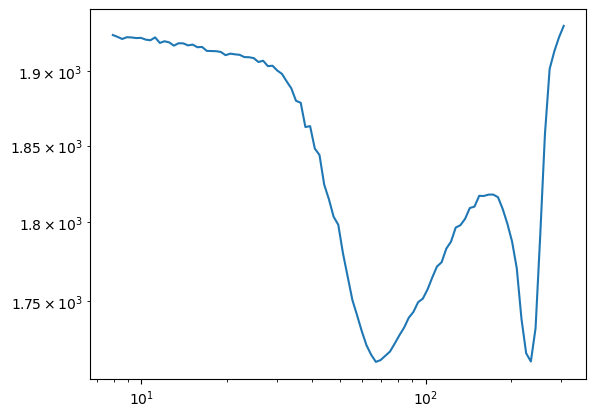

In [101]:
nbin = 150
rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(1.5*prop['r200']), num=nbin+1)

xx, yy = np.meshgrid(np.arange(0, 210), np.arange(0, 210))
dist = np.sqrt(xx**2 + yy**2)

leff_numerical_profile = []
leff_numerical_profile.append(np.nanmean(leff_numerical_map[(dist<=rbins_p[0])]))

for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    leff_numerical_profile = np.append(leff_numerical_profile, np.nanmedian(leff_numerical_map[(dist>rr0) & (dist<=rr1)]))

plt.loglog(rbins_p, leff_numerical_profile)


## Try with a Vikhlinin profile

In [103]:
nbin = 150
rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(2*r200_frac*prop['r200']), num=nbin+1)

xxx, yyy, zzz = np.meshgrid(x_ne_grid[0][:-1], x_ne_grid[1][:-1], x_ne_grid[2][:-1])

dist = np.sqrt(xxx**2 + yyy**2 + zzz**2)

h_ne2_3D = h_ne_3D**2

ne_prof = []
ne_prof_errs = []
ne_prof.append(np.nanmean(h_ne_3D[(dist<=rr[0])]))
ne_prof_errs.append(np.nanstd(h_ne_3D[(dist<=rr[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    ne_prof = np.append(ne_prof, np.nanmean(h_ne_3D[(dist>rr0) & (dist<=rr1)]))
    ne_prof_errs = np.append(ne_prof_errs, np.nanstd(h_ne_3D[(dist>rr0) & (dist<=rr1)]))

not_nan = np.where(~np.isnan(ne_prof))[0][1:]
ne_prof = ne_prof[not_nan]
rbins_p = rbins_p[not_nan]

/tmp/ipykernel_1724599/1480700414.py:15: RuntimeWarning: Mean of empty slice
  ne_prof = np.append(ne_prof, np.nanmean(h_ne_3D[(dist>rr0) & (dist<=rr1)]))
/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
def Vikhlinin_profile(r, n0, rc, rs, alpha, beta, epsilon):
    return np.sqrt(n0**2 * ((r/rc)**(-alpha)/(1+r**2/rc**2)**(3*beta-alpha/2)) * (1/(1+r**3/rs**3)**(epsilon/3)))

In [ ]:
ne_prof_errs = ne_prof_errs[not_nan]
popt_Vik, pcov_Vik = curve_fit(Vikhlinin_profile, rbins_p, ne_prof, p0 = (2e-3, 100, 1000, 0.5, 0.5, 3), maxfev=50000)
print(popt_Vik)

[ 4.27435028e-01  3.20915448e+01  4.74488316e+06 -7.28187050e+00
  7.18724091e-01 -1.74019812e+05]


/tmp/ipykernel_1603382/3839429690.py:2: RuntimeWarning: invalid value encountered in power
  return np.sqrt(n0**2 * ((r/rc)**(-alpha)/(1+r**2/rc**2)**(3*beta-alpha/2)) * (1/(1+r**3/rs**3)**(epsilon/3)))
/home/rwicker/.conda/envs/Tszx_project/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


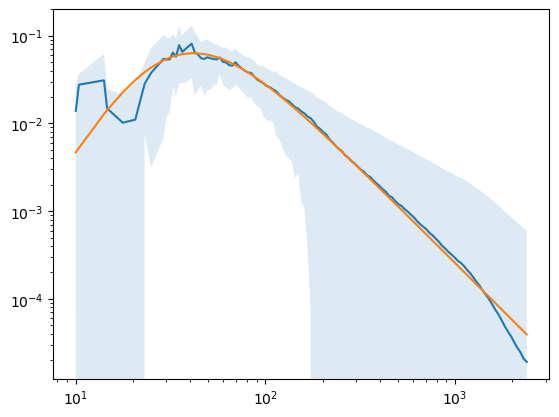

In [ ]:
plt.loglog(rbins_p, ne_prof)
plt.fill_between(rbins_p, ne_prof + ne_prof_errs, ne_prof-ne_prof_errs, alpha=0.15)
plt.loglog(rbins_p, Vikhlinin_profile(rbins_p, *popt_Vik))

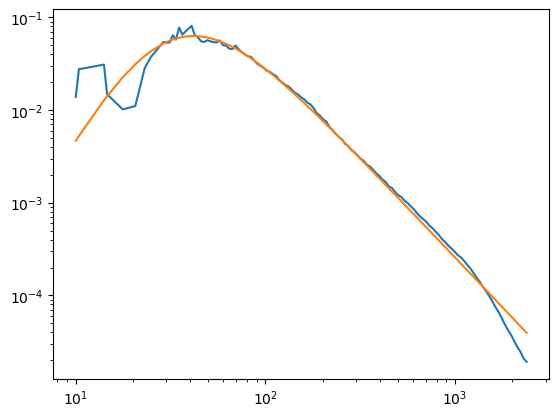

In [ ]:
plt.loglog(rbins_p, ne_prof)
plt.loglog(rbins_p, Vikhlinin_profile(rbins_p, *popt_Vik))

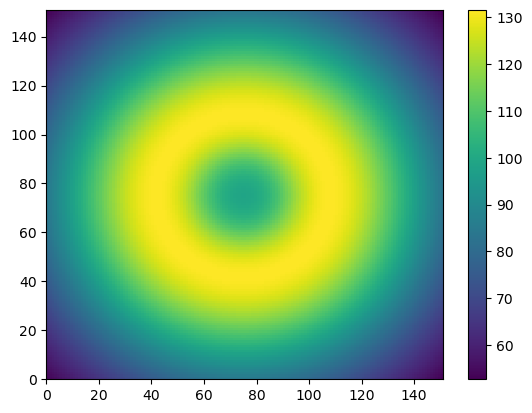

In [ ]:
vikhlinin_volume = Vikhlinin_profile(centeredDistanceMatrix3D(151), *popt_Vik)
test1 = plt.pcolormesh(np.nansum(vikhlinin_volume, axis=2)*(1.5*r200/len(vikhlinin_volume)))
plt.colorbar(test1)


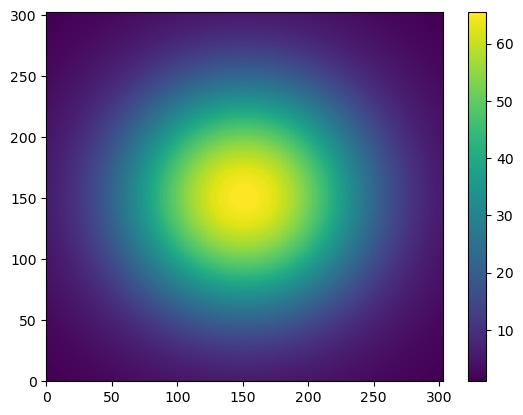

In [ ]:
test2 = plt.pcolormesh(np.nansum(ne_grid_to_fill, axis=2)*(1.5*r200/len(ne_grid_to_fill)))
plt.colorbar(test2)

In [ ]:
pixel_size = (3*r200)/len(vikhlinin_volume)
print(pixel_size, len(vikhlinin_volume), 3*r200)

31.60927152317881 151 4773.0


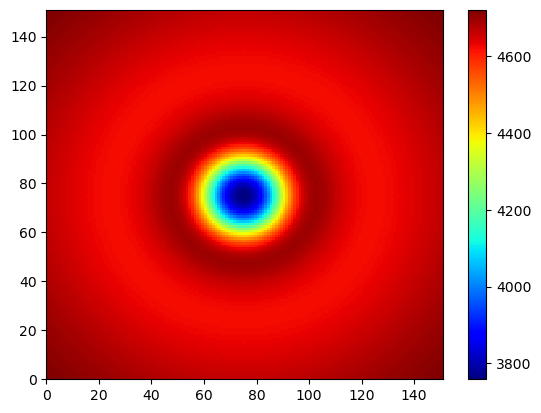

In [ ]:
vikhlinin_leff = (np.nansum(vikhlinin_volume, axis=2)*((3*r200)/len(vikhlinin_volume)))**2/(np.nansum(vikhlinin_volume**2, axis=2)*((3*r200)/len(vikhlinin_volume)))
vikhlinin_leff_map = plt.pcolormesh(vikhlinin_leff, cmap='jet')
plt.colorbar(vikhlinin_leff_map)

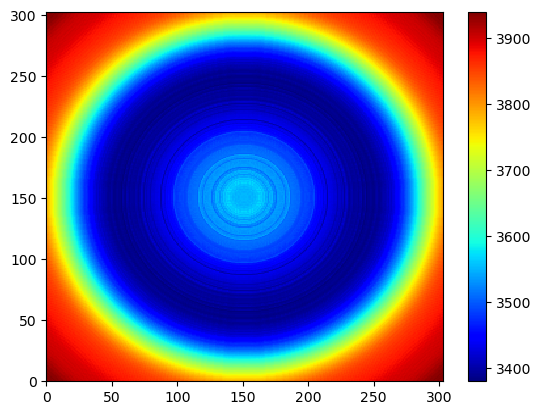

In [ ]:
numerical_prof_leff = (np.nansum(ne_grid_to_fill, axis=2)*((3*r200)/len(ne_grid_to_fill)))**2/(np.nansum(ne2_grid_to_fill, axis=2)*((3*r200)/len(ne_grid_to_fill)))
numerical_leff_map = plt.pcolormesh(numerical_prof_leff, cmap='jet')
plt.colorbar(numerical_leff_map)

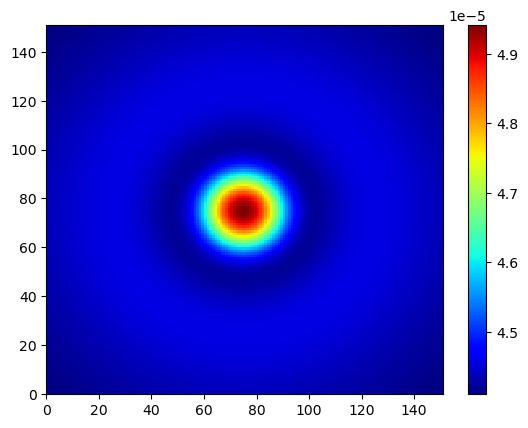

In [ ]:
vikhlinin_Q = np.sqrt(np.nansum(vikhlinin_volume**2, axis=2)/(len(vikhlinin_volume)))/np.nansum(vikhlinin_volume, axis=2)/(len(vikhlinin_volume))
vikhlinin_leffQ_map = plt.pcolormesh(vikhlinin_Q, cmap='jet')#r500/vikhlinin_Q**2
plt.colorbar(vikhlinin_leffQ_map)

# Try different integration lengths

In [40]:
leff_profiles = np.load('leff_profiles_0_5_to_10_R200.npy')
radial_bins = np.load('radial_bins_0_5_to_10_R200.npy')
Q2_profiles = np.load('Q2_profiles_0_5_to_10_R200.npy')

integration_lengths = np.logspace(np.log10(0.25), np.log10(5), 15)

In [27]:
print(leff_profiles, leff_profiles.shape)
print(radial_bins, radial_bins.shape)

[[ 601.66890798           nan           nan ...  767.10942917
   767.21619157  768.45512112]
 [ 667.16950378           nan           nan ...  938.77547566
   939.30445495  939.32196772]
 [1077.64452943           nan           nan ... 1143.14410802
  1146.29880719 1149.22418651]
 ...
 [3906.6439748            nan           nan ...  383.77195005
   355.39976529  351.14965734]
 [1117.13659499           nan           nan ...  384.80917609
   378.47002787  382.46170977]
 [1248.5637527            nan           nan ...  533.11082632
   527.38871427  522.28246985]] (15, 151)
[[   7.955         8.16519669    8.38094745 ...  377.53503053
   387.51072036  397.75      ]
 [   7.955         8.17685297    8.40489309 ...  466.28225995
   479.28617009  492.6527397 ]
 [   7.955         8.1885259     8.42890715 ...  575.891317
   592.79710411  610.19917519]
 ...
 [   7.955         8.30617559    8.67285392 ... 4756.16495325
  4966.12712047 5185.35812343]
 [   7.955         8.31803313    8.69763359 ... 587

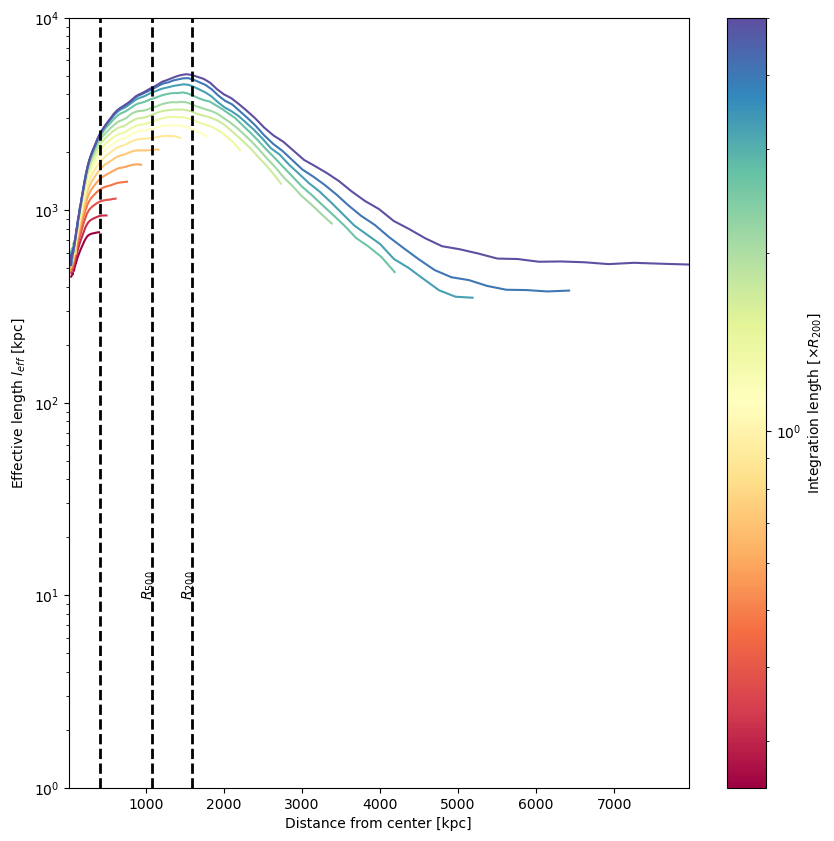

In [36]:
c_norm = colors.LogNorm(vmin=np.min(integration_lengths), vmax=np.max(integration_lengths))

# Pick a colormap
c_map  = cm.Spectral

# Scalar mappable of normalized array to colormap
s_map  = cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
for i, int_leng in enumerate(leff_profiles):
    ax1.loglog(radial_bins[i], int_leng, color=s_map.to_rgba(integration_lengths[i]))
ax1.set_yscale('log')
ax1.set_ylabel('Effective length $l_{eff}$ [kpc]')
ax1.set_xlabel('Distance from center [kpc]')
ax1.set_xlim(radial_bins[-1].min(), radial_bins[-1].max())
ax1.set_ylim(1., 1e4)
ax1.vlines([cosm.kpc_proper_per_arcmin(0.592).value, r500, r200], 1., 1e4, colors='k', ls='--', lw=2)
ax1.text(r500-150, 10, '$R_{500}$', rotation='vertical')
ax1.text(r200-150, 10, '$R_{200}$', rotation='vertical')
plt.colorbar(s_map, label=r'Integration length [$\times R_{200}$]', ax=ax1)

plt.savefig(f'{plot_dir}/Multiple_integration_lengths_leff.jpg')


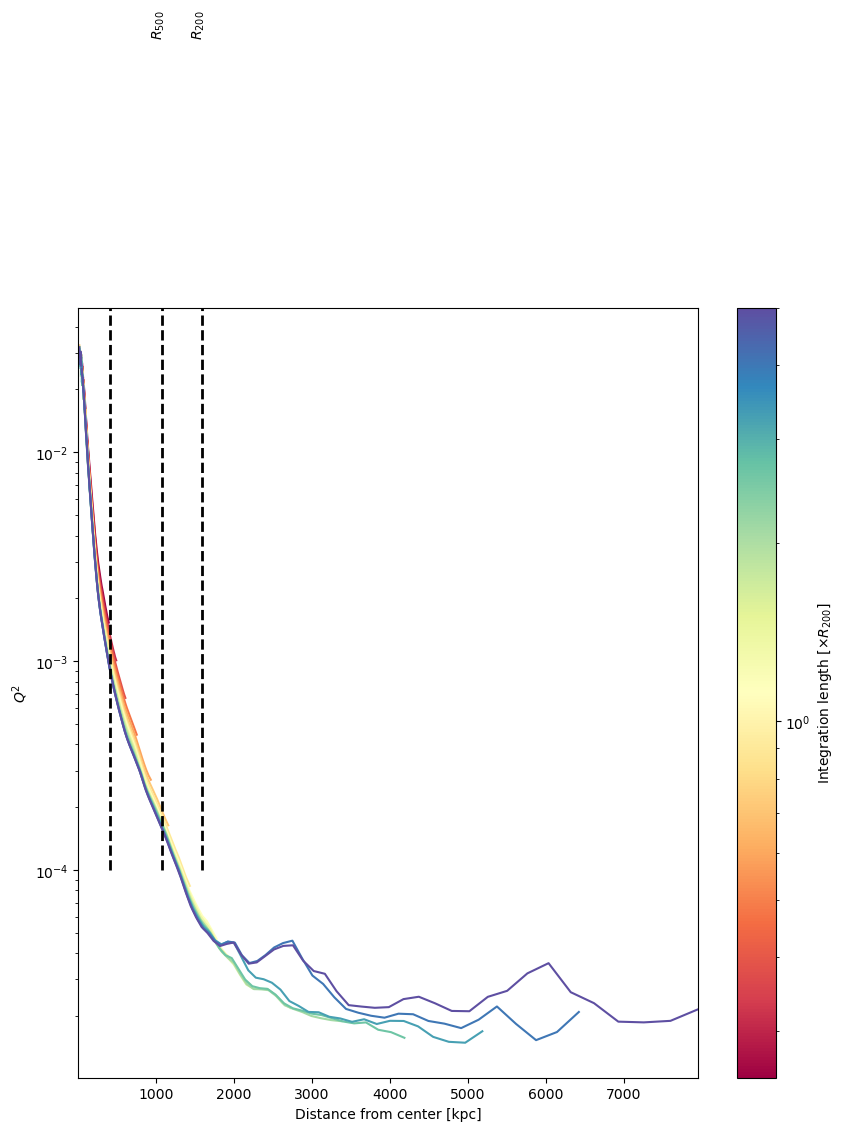

In [41]:
c_norm = colors.LogNorm(vmin=np.min(integration_lengths), vmax=np.max(integration_lengths))

# Pick a colormap
c_map  = cm.Spectral

# Scalar mappable of normalized array to colormap
s_map  = cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
for i, Q2 in enumerate(Q2_profiles):
    ax1.plot(radial_bins[i], Q2, color=s_map.to_rgba(integration_lengths[i]))
ax1.set_yscale('log')
ax1.set_ylabel('$Q^2$')
ax1.set_xlabel('Distance from center [kpc]')
ax1.set_xlim(radial_bins[-1].min(), radial_bins[-1].max())
#ax1.set_ylim(1., 1e4)
ax1.vlines([cosm.kpc_proper_per_arcmin(0.592).value, r500, r200], 1e-4, 1, colors='k', ls='--', lw=2)
ax1.text(r500-150, 0.01, '$R_{500}$', rotation='vertical')
ax1.text(r200-150, 0.01, '$R_{200}$', rotation='vertical')
plt.colorbar(s_map, label=r'Integration length [$\times R_{200}$]', ax=ax1)

plt.savefig(f'{plot_dir}/Multiple_integration_lengths_Q2.jpg')

# Testing things with the SPH maps

In [27]:
sph_cube_smoothed = np.load('test_sph_smoothed_map_3r200.npy')

In [28]:
density_sph_cube = sph_cube_smoothed/bin_cm**3

In [29]:
h_ne_grid, x_ne_grid = np.histogramdd([x,y,z], bins=(nbins+1, nbins+1, nbins+1), weights=np.float64(ne)/m_ptoMsun/0.6777 )
h_ne_grid = h_ne_grid.transpose()
h_ne_3D = h_ne_grid/bin_cm**3
h_ne_3D_smoothed = gaussian_filter(h_ne_3D, 3)

0.04744700029805715 0.7555033874477356


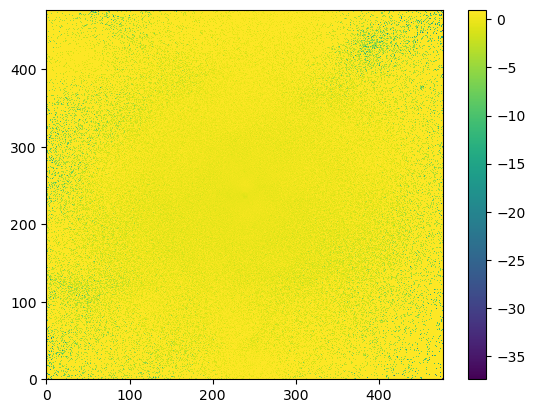

In [30]:
comparison_sph_gauss = (np.sum(density_sph_cube, axis=2)-np.sum(h_ne_3D, axis=2))/np.sum(density_sph_cube, axis=2)
test_map = plt.pcolormesh(comparison_sph_gauss)
plt.colorbar(test_map)
print(np.mean(comparison_sph_gauss), np.median(comparison_sph_gauss))

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.00000e+00, 2.00000e+00, 3.00000e+00, 0.00000e+00, 4.00000e+00,
        3.00000e+00, 5.00000e+00, 5.00000e+00, 6.00000e+00, 9.00000e+00,
        1.80000e+01, 1.90000e+01, 1.40000e+01, 1.50000e+01, 2.90000e+01,
        3.90000e+01, 5.10000e+01, 4.90000e+01, 8.10000e+01, 1.18000e+02,
        1.52000e+02, 2.09000e+02, 2.94000e+02, 3.83000e+02, 5.08000e+02,
        6.78000e+02, 1.08100e+03, 1.60100e+03, 2.54900e+03, 3.59400e+03,
        5.60000e+03, 9.63800e+03, 2.07860e+04, 4.57550e+04, 1.34223e+05]),
 array([-37.40520352, -36.63709945, -35.86899538, -35.10089131,
        -34.33278724, -33.56468317, -32.7965791 , -32.02847503,
        -31.26037096, -30.49226688, -29.72416281, -28.95605874,
        -28.18795467, -27.4198506 , -26.65174653, -25.88364246,
        -25.

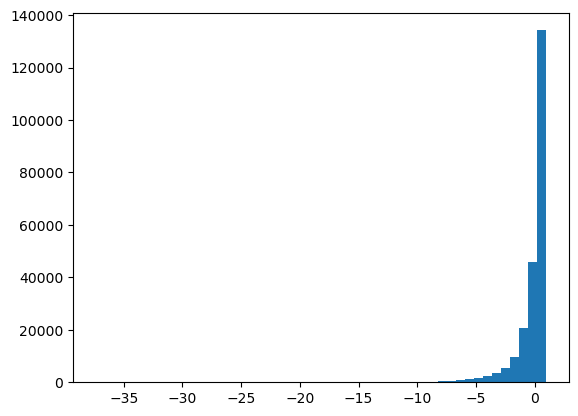

In [31]:
plt.hist(comparison_sph_gauss.flatten(), bins=50)

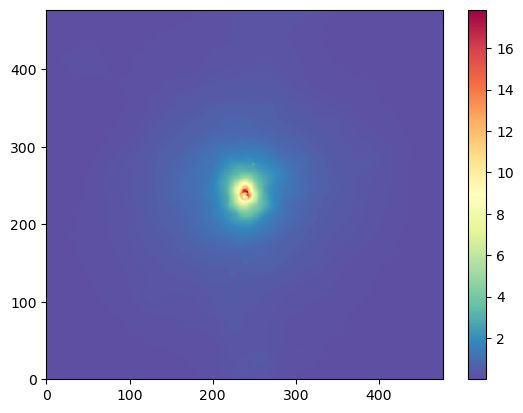

In [34]:
sph_leff = (np.sum(density_sph_cube, axis=2)*bin_kp)
sph_leff_map = plt.pcolormesh(sph_leff, cmap='Spectral_r')
plt.colorbar(sph_leff_map)

/tmp/ipykernel_2609515/225894177.py:1: RuntimeWarning: divide by zero encountered in divide
  comparison_sph_discrete = (np.sum(density_sph_cube, axis=2)*bin_kp) / (np.sum(h_ne_3D**2, axis=2)*bin_kp)


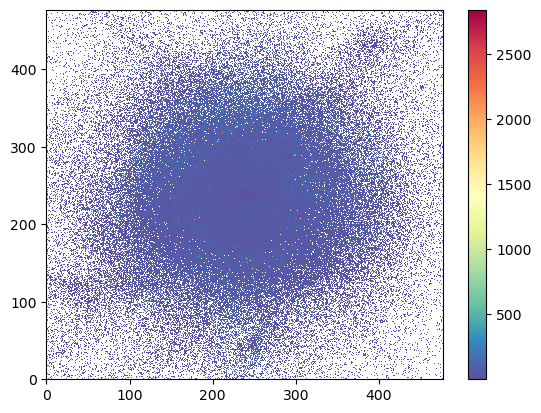

In [35]:
comparison_sph_discrete = (np.sum(density_sph_cube, axis=2)*bin_kp) / (np.sum(h_ne_3D**2, axis=2)*bin_kp)
sph_v_discrete = plt.pcolormesh(comparison_sph_discrete, cmap='Spectral_r')
plt.colorbar(sph_v_discrete)

<function matplotlib.pyplot.savefig(*args, **kwargs) -> 'None'>

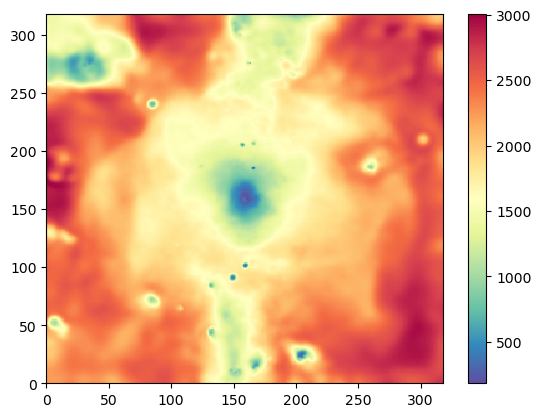

In [35]:
density_sph_cube = np.load('test_sph_smoothed_ne_map_3.0r200.npy')/bin_cm**3
Qsph = (np.sum(density_sph_cube, axis=2)*bin_kp)**2/(np.sum(density_sph_cube**2, axis=2)*bin_kp)

#Qcomparison_sph_discrete = (np.sum(density_sph_cube, axis=2)*bin_kp) / (np.sum(h_ne_3D**2, axis=2)*bin_kp)
sph_v_discrete = plt.pcolormesh(Qsph, cmap='Spectral_r')
plt.colorbar(sph_v_discrete)

plt.savefig

In [52]:
ne_sph_cube_smoothed = np.load('test_sph_smoothed_ne_map_3.0r200.npy')/bin_cm**3
ne2_sph_cube_smoothed = np.load('test_sph_smoothed_ne2_map_3.0r200.npy')/bin_cm**3

In [53]:
ne_sph_int = np.sum(ne_sph_cube_smoothed, axis=2)*bin_kp
ne2_sph_int = np.sum(ne2_sph_cube_smoothed, axis=2)*bin_kp

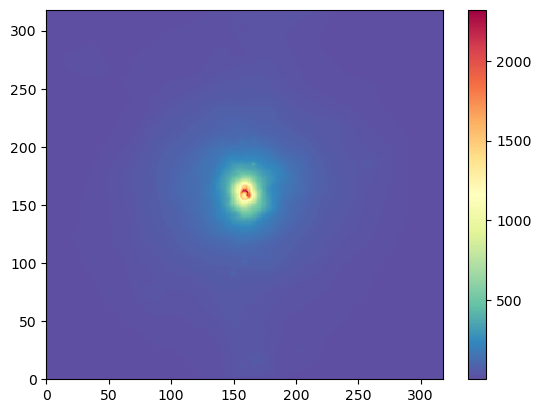

In [54]:
sph_leff = np.divide(ne_sph_int**2, ne2_sph_int)
sph_leff_map = plt.pcolormesh(sph_leff, cmap='Spectral_r')
plt.colorbar(sph_leff_map)

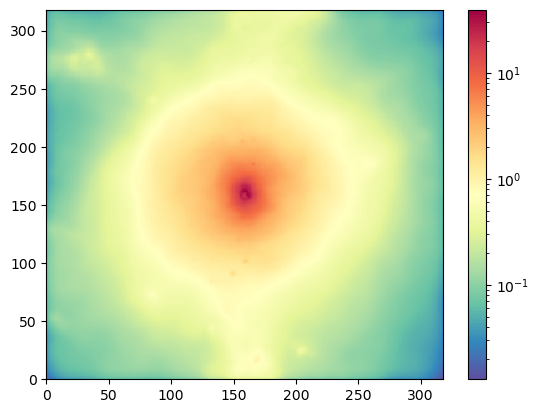

In [60]:
ne_map = plt.pcolormesh(ne_sph_int, cmap='Spectral_r', norm=LogNorm())
plt.colorbar(ne_map)

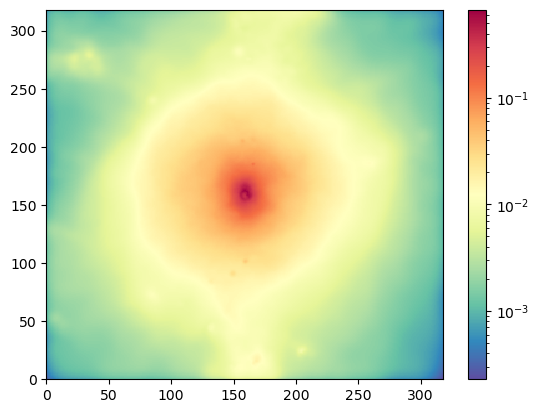

In [59]:
ne2_map = plt.pcolormesh(ne2_sph_int, cmap='Spectral_r', norm=LogNorm())
plt.colorbar(ne2_map)

In [36]:
r200_frac = 1.5

psize = 2*r200_frac*r200/len(Qsph)
r500_pix = r500/psize
r200_pix = r200/psize

distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(Qsph)*psize//2, len(Qsph)*psize//2, len(Qsph)), 
                                               np.linspace(-len(Qsph)*psize//2, len(Qsph)*psize//2, len(Qsph)))

arcmin_grid_x = distance_grid_x / cosm.kpc_proper_per_arcmin(0.592).value
arcmin_grid_y = distance_grid_y / cosm.kpc_proper_per_arcmin(0.592).value
r500_arcmin = r500/cosm.kpc_proper_per_arcmin(0.592).value
r200_arcmin = r200/cosm.kpc_proper_per_arcmin(0.592).value

print(psize)

15.00943396226415


In [37]:
grid_to_pick_x = distance_grid_x #arcmin_grid_x
grid_to_pick_y = distance_grid_y #arcmin_grid_y
r500_to_pick = r500 #r500_arcmin
r200_to_pick = r200 #r200_arcmin
radius_1arcmin = cosm.kpc_proper_per_arcmin(0.592).value #1

print(radius_1arcmin)

410.57846661339755


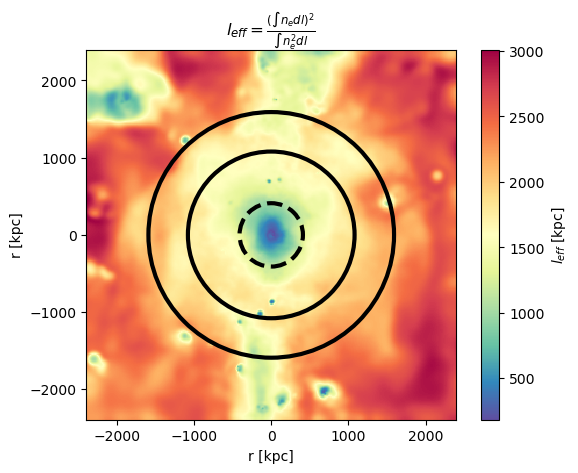

In [38]:
fig =plt.figure()
ax1=fig.add_subplot(111, aspect='equal')
test_leffmap = plt.pcolormesh(grid_to_pick_x, grid_to_pick_y, Qsph, cmap='Spectral_r')
circle_R500 = plt.Circle((0., 0.),
                        r500_to_pick, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.),
                        r200_to_pick, color='k', fill=False, lw=3)
circle_1arcmin = plt.Circle((0., 0.),
                        radius_1arcmin, color='k', fill=False, lw=3, ls='--')
ax1.add_artist(circle_R200)
ax1.add_artist(circle_R500)
ax1.add_artist(circle_1arcmin)
ax1.set_title(r'$l_{eff} = \frac{(\int n_e dl)^2}{\int n_e^2 dl}$')
if grid_to_pick_x.all() == distance_grid_x.all():
    ax1.set_xlabel('r [kpc]')
    ax1.set_ylabel('r [kpc]')
else :
    ax1.set_xlabel(r'$\theta$ [arcmin]')
    ax1.set_ylabel(r'$\theta$ [arcmin]')
plt.colorbar(test_leffmap, label = '$l_{eff}$ [kpc]')

plt.savefig(f'{plot_dir}/leff_map_sph_3r200.jpg')

In [39]:
print(density_sph_cube.shape, density_sph_cube)

(318, 318, 318) [[[1.80758139e-65 1.97194281e-65 2.21062727e-65 ... 8.53972439e-64
   7.89538836e-64 7.25664374e-64]
  [2.26081432e-65 2.48600429e-65 2.81161101e-65 ... 9.08967055e-64
   8.40981196e-64 7.73522367e-64]
  [2.79731086e-65 3.09735941e-65 3.52839672e-65 ... 9.63155071e-64
   8.91707092e-64 8.20750735e-64]
  ...
  [1.45596948e-63 1.50757180e-63 1.55088856e-63 ... 1.72910188e-63
   1.52015892e-63 1.32837735e-63]
  [1.39517734e-63 1.44378998e-63 1.48443434e-63 ... 1.61527278e-63
   1.41577085e-63 1.23225216e-63]
  [1.32897368e-63 1.37455852e-63 1.41253760e-63 ... 1.50085513e-63
   1.31145703e-63 1.13692072e-63]]

 [[1.95279819e-65 2.14699931e-65 2.42790138e-65 ... 9.29971543e-64
   8.60905054e-64 7.92293789e-64]
  [2.44192481e-65 2.70542360e-65 3.08447998e-65 ... 9.91591378e-64
   9.18587565e-64 8.46000536e-64]
  [3.02007355e-65 3.36801147e-65 3.86506076e-65 ... 1.05260288e-63
   9.75743376e-64 8.99256277e-64]
  ...
  [1.53732690e-63 1.59219967e-63 1.63828509e-63 ... 2.0366914

## SPH for 7 $R_{200}$ , pixels of 20 kpc

In [26]:
r200_frac = 3.5
pixel_size = 20

nbins = int(prop['r200']*r200_frac/pixel_size)*2
rbins = np.linspace(-prop['r200']*r200_frac, prop['r200']*r200_frac, num=nbins+1)

bin_kp = np.abs((rbins [0]-rbins[1]))#*prop['r200'])
bin_cm = bin_kp*const.kpc.to('cm').value #unit: (cm/h)^3	

vol = bin_kp**3  #unit: (kpc/h)^3
volcm = vol*const.kpc.to('cm').value**3 #unit: (cm/h)^3	


In [27]:
ne_sph = np.load('test_sph_smoothed_ne_map_7.0r200.npy')
summed_ne = np.sum(ne_sph,axis=2)*bin_kp
summed_ne2 = np.sum(ne_sph**2,axis=2)*bin_kp

leff_map = summed_ne**2/summed_ne2

psize = 2*r200_frac*r200/len(leff_map)
print(psize)
r500_pix = r500/psize
r200_pix = r200/psize

distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(leff_map)*psize//2, len(leff_map)*psize//2, len(leff_map)), 
                                               np.linspace(-len(leff_map)*psize//2, len(leff_map)*psize//2, len(leff_map)))

arcmin_grid_x = distance_grid_x / cosm.kpc_proper_per_arcmin(0.592).value
arcmin_grid_y = distance_grid_y / cosm.kpc_proper_per_arcmin(0.592).value
r500_arcmin = r500/cosm.kpc_proper_per_arcmin(0.592).value
r200_arcmin = r200/cosm.kpc_proper_per_arcmin(0.592).value
radius_1arcmin = cosm.kpc_proper_per_arcmin(0.592).value

20.030575539568346


In [28]:
chosen_grid = 'distance'

In [29]:
if chosen_grid == 'distance':
    grid_to_pick_x = distance_grid_x #arcmin_grid_x
    grid_to_pick_y = distance_grid_y #arcmin_grid_y
    r500_to_pick = r500 #r500_arcmin
    r200_to_pick = r200 #r200_arcmin
    radius_1arcmin = cosm.kpc_proper_per_arcmin(0.592).value #1
elif chosen_grid == 'angle':
    grid_to_pick_x = arcmin_grid_x
    grid_to_pick_y = arcmin_grid_y
    r500_to_pick = r500_arcmin
    r200_to_pick = r200_arcmin
    radius_1arcmin = 1.
print(radius_1arcmin)

410.57846661339755


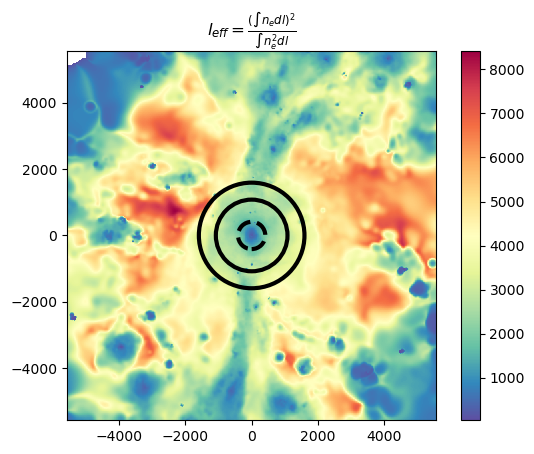

In [30]:
fig =plt.figure()#figsize=(10,10))
ax1=fig.add_subplot(111, aspect='equal')
test_leffmap = plt.pcolormesh(grid_to_pick_x, grid_to_pick_y, leff_map, cmap='Spectral_r')
circle_R500 = plt.Circle((0., 0.), r500_to_pick, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200_to_pick, color='k', fill=False, lw=3)
circle_1arcmin = plt.Circle((0., 0.), radius_1arcmin, color='k', fill=False, lw=3, ls='--')
ax1.add_artist(circle_R200)
ax1.add_artist(circle_R500)
ax1.add_artist(circle_1arcmin)
ax1.set_title(r'$l_{eff} = \frac{(\int n_e dl)^2}{\int n_e^2 dl}$')
plt.colorbar(test_leffmap)

plt.savefig(f'{plot_dir}/SPH_leff_pix{int(psize)}kpc_{int(2*r200_frac)}r200.png')

/home/rwicker/.conda/envs/Tszx_project/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/rwicker/.conda/envs/Tszx_project/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[          nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan  465.00406437
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan  416.33795013           nan           nan
           nan           nan           nan           nan  393.59430901
           nan           nan           nan  392.81639072           nan
           nan  412.41163895           nan           nan           nan
           nan  453.01710599  482.68752295           nan           nan
  514.4640716   511.23212821  554.6467233   589.9868577   587.54827304
           nan  609.44814572  649.50908688  681.77521357  678.4367509
  705.15479911  744.36333015  759.06055904  743.20710075  801.87665257
  856.4

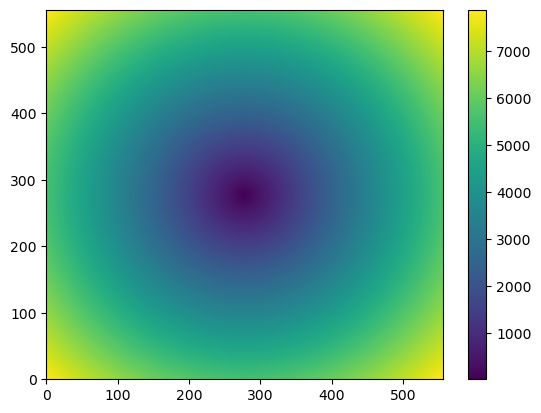

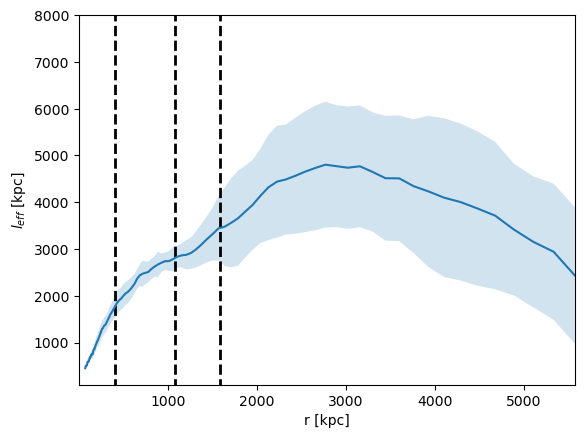

In [31]:
nbin = 150
rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(r200_frac*prop['r200']), num=nbin+1)

#print(rbins_p, rbins_p.max()/(r200_frac*prop['r200']))

xx, yy = np.meshgrid(np.linspace(-rbins_p.max(), rbins_p.max(), len(leff_map)),
                     np.linspace(-rbins_p.max(), rbins_p.max(), len(leff_map)))
dist = np.sqrt(xx**2 + yy**2)

dist_map = plt.pcolormesh(dist)
plt.colorbar(dist_map)
    
leff_prof = []
leff_errs = []
leff_prof.append(np.nanmedian(leff_map[(dist<=rbins_p[0])]))
leff_errs.append(np.nanstd(leff_map[(dist<=rbins_p[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    leff_prof = np.append(leff_prof, np.nanmedian(leff_map[(dist>rr0) & (dist<=rr1)]))
    leff_errs = np.append(leff_errs, np.nanstd(leff_map[(dist>rr0) & (dist<=rr1)]))
print(leff_prof)
fig = plt.figure()
ax=fig.add_subplot(111)
ax.fill_between(rbins_p, leff_prof - leff_errs, leff_prof + leff_errs, alpha = 0.2)
ax.plot(rbins_p, leff_prof)
ax.vlines([radius_1arcmin, r500, r200], 1., 1e4, colors='k', ls='--', lw=2)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('$l_{eff}$ [kpc]')
#ax.set_yscale('log')
ax.set_ylim(1e2, 8e3)
ax.set_xlim(1., rbins_p.max())
plt.savefig(f'{plot_dir}/leff_profile_sph.png')
plt.show()

NameError: name 'leff_test_map' is not defined

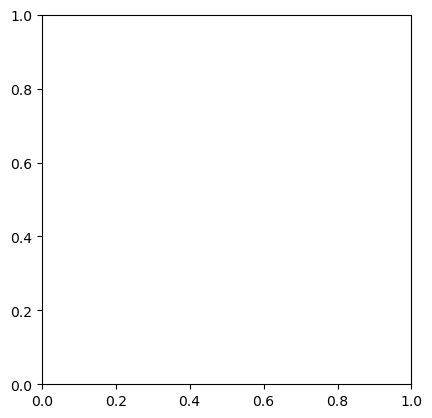

In [32]:
fig =plt.figure()
ax1=fig.add_subplot(111, aspect='equal')
comp_sph_gauss = plt.pcolormesh(grid_to_pick_x, grid_to_pick_y, (leff_map-leff_test_map)/leff_map, cmap='Spectral', vmin=-1., vmax=1.)
circle_R500 = plt.Circle((0., 0.),
                        r500_to_pick, color='k', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.),
                        r200_to_pick, color='k', fill=False, lw=3)
circle_1arcmin = plt.Circle((0., 0.),
                        radius_1arcmin, color='k', fill=False, lw=3, ls='--')
ax1.add_artist(circle_R200)
ax1.add_artist(circle_R500)
ax1.add_artist(circle_1arcmin)
ax1.set_title(r'$(l_{eff, SPH}-l_{eff, Gauss})/l_{eff, SPH}$')
if grid_to_pick_x.all() == distance_grid_x.all():
    ax1.set_xlabel('r [kpc]')
    ax1.set_ylabel('r [kpc]')
else :
    ax1.set_xlabel(r'$\theta$ [arcmin]')
    ax1.set_ylabel(r'$\theta$ [arcmin]')
plt.colorbar(comp_sph_gauss)

plt.savefig(f'{plot_dir}/comparison_sph_gauss_leffs.png')

# Temperature constraints using SPH smoothed maps (working at $4R_{200}$ of integration, with pixel size of $10 kpc$)

In [108]:
r200_frac = 2
pixel_size = 10

nbins = int(prop['r200']*r200_frac/pixel_size)*2
rbins = np.linspace(-prop['r200']*r200_frac, prop['r200']*r200_frac, num=nbins+1)

bin_kp = np.abs((rbins [0]-rbins[1]))#*prop['r200'])
bin_cm = bin_kp*const.kpc.to('cm').value #unit: (cm/h)^3	

vol = bin_kp**3  #unit: (kpc/h)^3
volcm = vol*const.kpc.to('cm').value**3 #unit: (cm/h)^3	

In [109]:
non_smoothed_part_cube = np.histogramdd([x,y,z], bins = (nbins, nbins, nbins))[0]

In [110]:
print(nbins, bin_kp, bin_cm)

860 10.007395348837235 3.087959547702804e+22


In [111]:
parts_cube_sph = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_parts_map_4r200.npy')

In [112]:
temperature_cube_sph = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_temp_map_4r200.npy')/parts_cube_sph

/tmp/ipykernel_3234614/2017981895.py:1: RuntimeWarning: divide by zero encountered in divide
  temperature_cube_sph = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_temp_map_4r200.npy')/parts_cube_sph
/tmp/ipykernel_3234614/2017981895.py:1: RuntimeWarning: invalid value encountered in divide
  temperature_cube_sph = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_temp_map_4r200.npy')/parts_cube_sph


In [113]:
density_cube_sph = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_ne_map_4r200.npy')

In [114]:
mass_cube_sph = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_mass_map_4r200.npy')

In [115]:
pressure_cube_sph = (temperature_cube_sph*mass_cube_sph)/(bin_cm**3*0.6125*m_ptoMsun*0.6777**2*(1 + 1/1.1568))

In [116]:
print(density_cube_sph.shape, temperature_cube_sph.shape, mass_cube_sph.shape)

(860, 860, 860) (860, 860, 860) (860, 860, 860)


### Computing $n_e$, $n_e^2$ and $l_{eff}$

In [117]:
density_map = np.sum(density_cube_sph, axis=2)*bin_kp
density_sq_map = np.sum(density_cube_sph**2, axis=2)*bin_kp

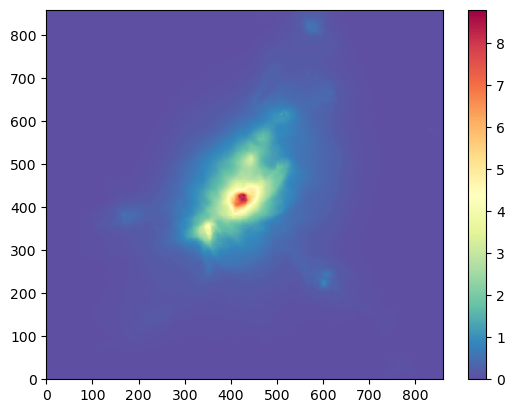

In [118]:
ne_map_plot = plt.pcolormesh(density_map, cmap='Spectral_r')
plt.colorbar(ne_map_plot)

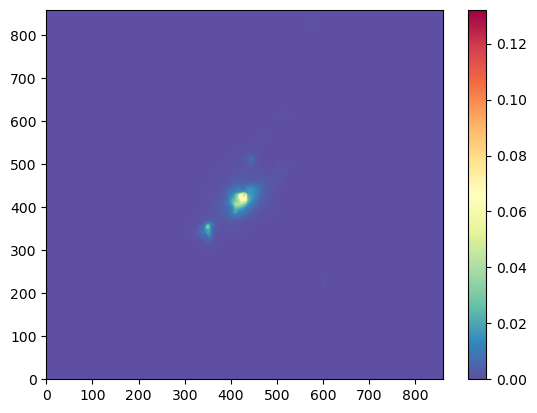

In [119]:
ne2_map_plot = plt.pcolormesh(density_sq_map, cmap='Spectral_r')
plt.colorbar(ne2_map_plot)

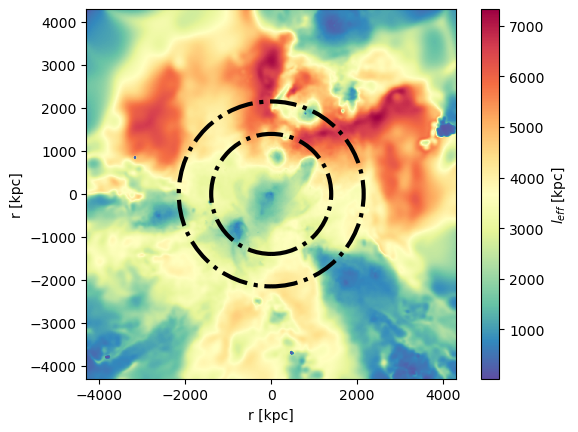

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
eff_len_map = density_map**2/density_sq_map

distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
leff_map = ax.pcolormesh(distance_grid_x, distance_grid_y, eff_len_map, cmap='Spectral_r')
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')
plt.colorbar(leff_map, label = '$l_{eff}$ [kpc]')

plt.savefig(f'{plot_dir}/Leff_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

### Derivation of theoretical temperature map (to check again)

In [121]:
print(nbins, bin_kp)

860 10.007395348837235


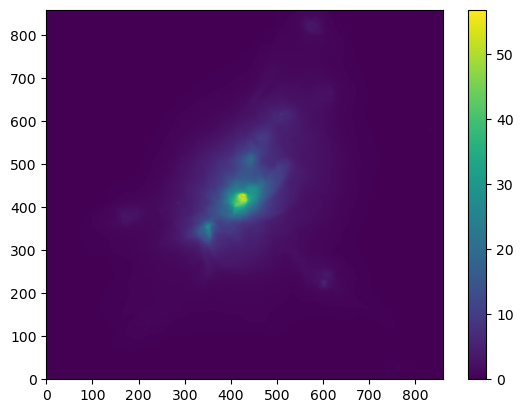

In [122]:
part_nums = plt.pcolormesh(np.sum(parts_cube_sph, axis=2))
plt.colorbar(part_nums)

In [123]:
xx, yy = np.meshgrid(np.linspace(-r200_frac*r200, r200_frac*r200, nbins),
                     np.linspace(-r200_frac*r200, r200_frac*r200, nbins))

In [124]:
integrated_temp_map = np.sum(temperature_cube_sph*parts_cube_sph, axis=2)*bin_kp/(np.sum(parts_cube_sph, axis=2)*bin_kp)

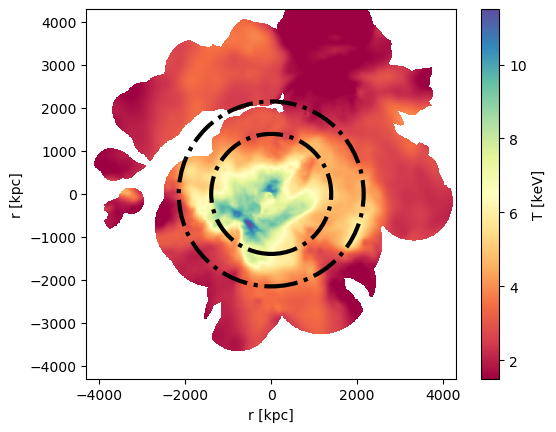

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
integrated_temp = ax.pcolormesh(distance_grid_x, distance_grid_y, integrated_temp_map, cmap='Spectral', vmin=1.5, vmax=11.5)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(integrated_temp, label='T [keV]')

plt.savefig(f'{plot_dir}/T_theo_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

### Derivation of mass-weighted temperature

In [126]:
mass_weighted_temp = (np.sum(temperature_cube_sph*mass_cube_sph, axis=2)*bin_kp)/(np.sum(mass_cube_sph, axis=2)*bin_kp)

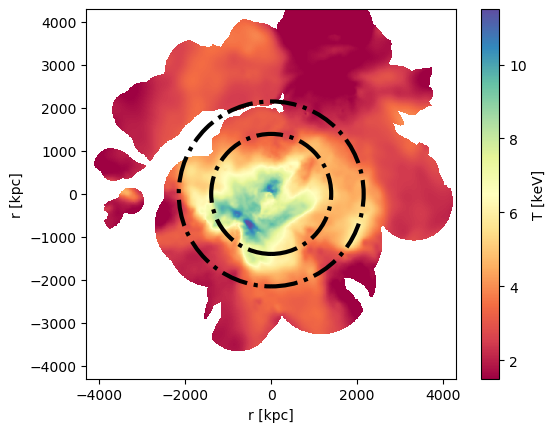

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
Tmw_map = ax.pcolormesh(distance_grid_x, distance_grid_y, mass_weighted_temp, cmap='Spectral', vmin=1.5, vmax=11.5)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(Tmw_map, label='T [keV]')

plt.savefig(f'{plot_dir}/T_mw_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

### Derivation of spectro-like temperature

In [128]:
spectro_like_temp = (np.sum(temperature_cube_sph*(density_cube_sph**2/temperature_cube_sph**(3/4)), axis=2)*bin_kp)/(np.sum((density_cube_sph**2/temperature_cube_sph**(3/4)), axis=2)*bin_kp)

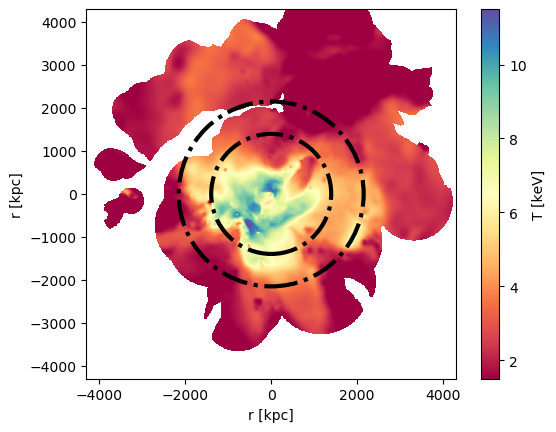

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
Tsl_map = ax.pcolormesh(distance_grid_x, distance_grid_y, spectro_like_temp, cmap='Spectral', vmin=1.5, vmax=11.5)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(Tsl_map, label='T [keV]')

plt.savefig(f'{plot_dir}/T_sl_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

In [130]:
np.save(f'/data7/NIKA2-300th/rwicker/comparison_maps_SPLASH_v_Weiguang_SPH/Weiguang_SPH_Ttheo_map_CL{crn:04d}_snap_{sn:03d}.npy', integrated_temp_map)
np.save(f'/data7/NIKA2-300th/rwicker/comparison_maps_SPLASH_v_Weiguang_SPH/Weiguang_SPH_Tmw_map_CL{crn:04d}_snap_{sn:03d}.npy', mass_weighted_temp)
np.save(f'/data7/NIKA2-300th/rwicker/comparison_maps_SPLASH_v_Weiguang_SPH/Weiguang_SPH_Tsl_map_CL{crn:04d}_snap_{sn:03d}.npy', spectro_like_temp)
np.save(f'/data7/NIKA2-300th/rwicker/comparison_maps_SPLASH_v_Weiguang_SPH/Weiguang_SPH_leff_map_CL{crn:04d}_snap_{sn:03d}.npy', eff_len_map)

print(integrated_temp_map.shape, mass_weighted_temp.shape, spectro_like_temp.shape, eff_len_map.shape)

(860, 860) (860, 860) (860, 860) (860, 860)


### Comparison $T_{mw} - T_{sl}$, $T_{mw} - T_{theo}$, $T_{sl} - T_{theo}$

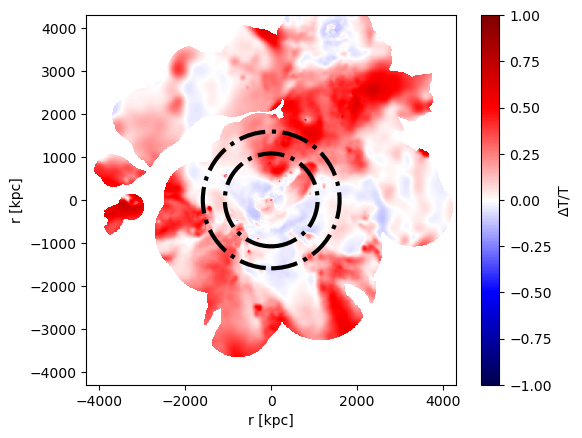

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
comparison_sl_mw = ax.pcolormesh(distance_grid_x, distance_grid_y, (mass_weighted_temp-spectro_like_temp)/mass_weighted_temp, cmap='seismic', vmin=-1, vmax=1)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(comparison_sl_mw, label='$\Delta$T/T')

plt.savefig(f'{plot_dir}/comp_mw_sl_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

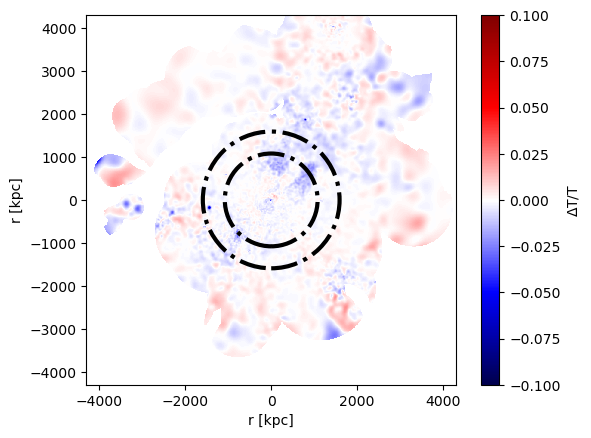

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
comparison_theo_mw = ax.pcolormesh(distance_grid_x, distance_grid_y, (integrated_temp_map-mass_weighted_temp)/integrated_temp_map, cmap='seismic', vmin=-0.1, vmax=0.1)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(comparison_theo_mw, label='$\Delta$T/T')

plt.savefig(f'{plot_dir}/comp_theo_mw_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

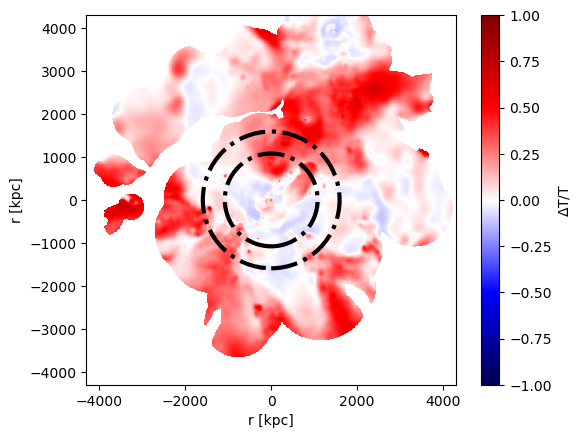

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
comparison_theo_sl = ax.pcolormesh(distance_grid_x, distance_grid_y, (integrated_temp_map-spectro_like_temp)/integrated_temp_map, cmap='seismic', vmin=-1, vmax=1)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(comparison_theo_sl, label='$\Delta$T/T')

plt.savefig(f'{plot_dir}/comp_theo_sl_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

### Derivation of pressure map, of $T_{SZX}$ map

In [118]:
integrated_pressure = np.sum(pressure_cube_sph, axis=2)*bin_kp

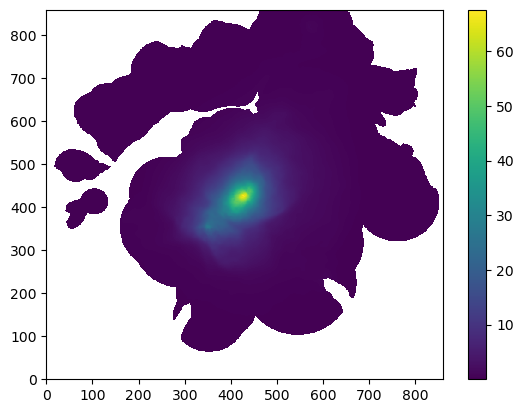

In [119]:
pressure_map = plt.pcolormesh(integrated_pressure)
plt.colorbar(pressure_map)

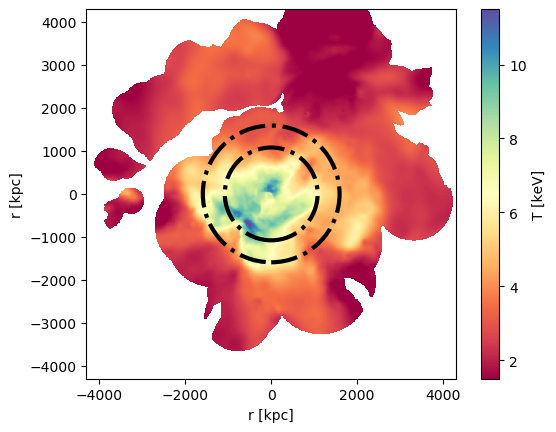

In [120]:
Tszx_map = integrated_pressure/density_map

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
Tszx = ax.pcolormesh(distance_grid_x, distance_grid_y, Tszx_map, cmap='Spectral', vmin=1.5, vmax=11.5)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(Tszx, label='T [keV]')

plt.savefig(f'{plot_dir}/T_szx_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

### Comparison $T_{SZX} - T_{mw}$, $T_{SZX} - T_{theo}$, $T_{SZX} - T_{sl}$

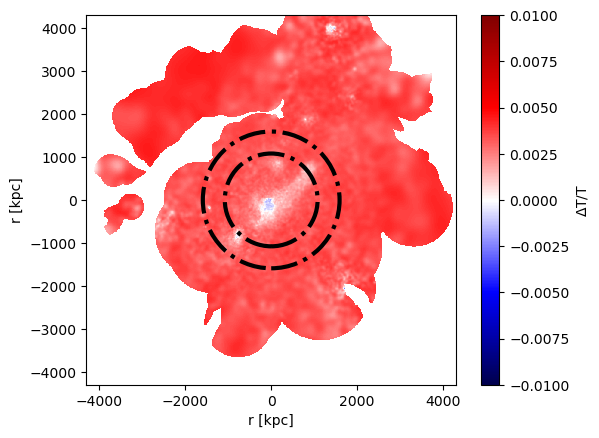

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
comparison_Tszx_Tmw = ax.pcolormesh(distance_grid_x, distance_grid_y, (mass_weighted_temp-Tszx_map)/mass_weighted_temp, cmap='seismic', vmin=-0.01, vmax=0.01)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(comparison_Tszx_Tmw, label='$\Delta$T/T')

plt.savefig(f'{plot_dir}/comp_tszx_mw_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

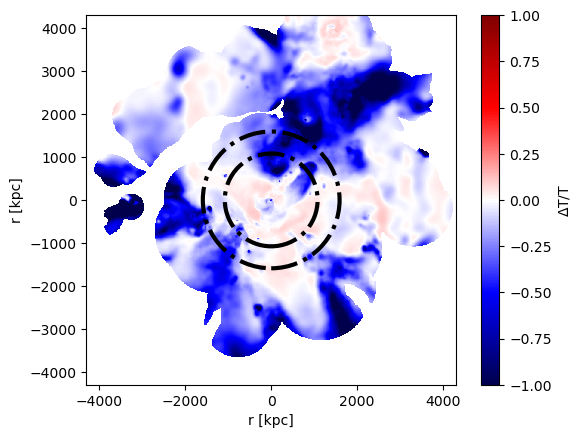

In [122]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
comparison_Tszx_Tsl = ax.pcolormesh(distance_grid_x, distance_grid_y, (spectro_like_temp-Tszx_map)/spectro_like_temp, cmap='seismic', vmin=-1, vmax=1)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(comparison_Tszx_Tsl, label='$\Delta$T/T')

plt.savefig(f'{plot_dir}/comp_tszx_sl_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

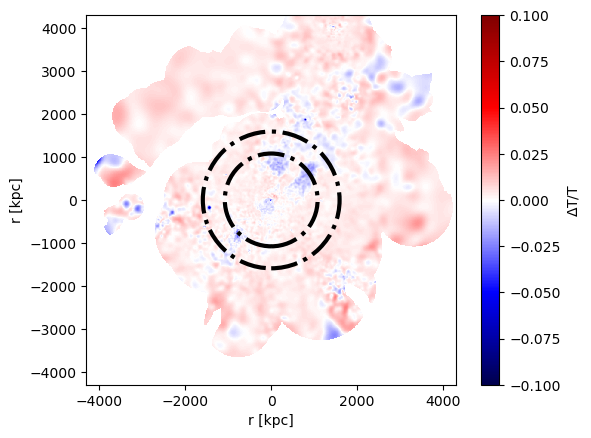

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
distance_grid_x, distance_grid_y = np.meshgrid(np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)), 
                                               np.linspace(-len(eff_len_map)*pixel_size//2, len(eff_len_map)*pixel_size//2, len(eff_len_map)))
circle_R500 = plt.Circle((0., 0.), r500, color='k', ls = '-.', fill=False, lw=3)
circle_R200 = plt.Circle((0., 0.), r200, color='k', ls = '-.', fill=False, lw=3)
comparison_Tszx_theo = ax.pcolormesh(distance_grid_x, distance_grid_y, (integrated_temp_map-Tszx_map)/integrated_temp_map, cmap='seismic', vmin=-0.1, vmax=0.1)#, norm=colors.LogNorm())
ax.add_artist(circle_R200)
ax.add_artist(circle_R500)
ax.set_xlabel('r [kpc]')
ax.set_ylabel('r [kpc]')

plt.colorbar(comparison_Tszx_theo, label='$\Delta$T/T')

plt.savefig(f'{plot_dir}/comp_tszx_theo_map_CL{crn:04d}_snap{sn}_{int(2*r200_frac)}R200.png')

## Comparison of integrated values $T_{500}$

In [59]:
xx, yy = np.meshgrid(np.linspace(-r200_frac*r200, r200_frac*r200, len(integrated_temp_map)),
                     np.linspace(-r200_frac*r200, r200_frac*r200, len(integrated_temp_map)))
dist = np.sqrt(xx**2 + yy**2)

In [60]:
nbin_prof = 150
rbins_p = np.logspace(np.log10(0.005*prop['r200']), np.log10(r200_frac*prop['r200']), num=nbin_prof+1)

In [61]:
T500_theo = []
T500_mw = []
T500_sl = []
T500_szx = []

T500_theo_err = []
T500_mw_err = []
T500_sl_err = []
T500_szx_err = []

T500_theo.append(np.nanmean(integrated_temp_map[(dist<=rbins_p[0])]))
T500_mw.append(np.nanmean(mass_weighted_temp[(dist<=rbins_p[0])]))
T500_sl.append(np.nanmean(spectro_like_temp[(dist<=rbins_p[0])]))
T500_szx.append(np.nanmean(Tszx_map[(dist<=rbins_p[0])]))

T500_theo_err.append(np.nanstd(integrated_temp_map[(dist<=rbins_p[0])]))
T500_mw_err.append(np.nanstd(mass_weighted_temp[(dist<=rbins_p[0])]))
T500_sl_err.append(np.nanstd(spectro_like_temp[(dist<=rbins_p[0])]))
T500_szx_err.append(np.nanstd(Tszx_map[(dist<=rbins_p[0])]))
for i, (rr0, rr1) in enumerate(zip(rbins_p[:-1], rbins_p[1:])):
    T500_theo = np.append(T500_theo, np.nanmean(integrated_temp_map[(dist>rr0) & (dist<=rr1)]))
    T500_mw = np.append(T500_mw, np.nanmean(mass_weighted_temp[(dist>rr0) & (dist<=rr1)]))
    T500_sl = np.append(T500_sl, np.nanmean(spectro_like_temp[(dist>rr0) & (dist<=rr1)]))
    T500_szx = np.append(T500_szx, np.nanmean(Tszx_map[(dist>rr0) & (dist<=rr1)]))

    T500_theo_err = np.append(T500_theo_err, np.std(integrated_temp_map[(dist>rr0) & (dist<=rr1)]))
    T500_mw_err = np.append(T500_mw_err, np.std(mass_weighted_temp[(dist>rr0) & (dist<=rr1)]))
    T500_sl_err = np.append(T500_sl_err, np.std(spectro_like_temp[(dist>rr0) & (dist<=rr1)]))
    T500_szx_err = np.append(T500_szx_err, np.std(Tszx_map[(dist>rr0) & (dist<=rr1)]))

/tmp/ipykernel_2779732/1539670219.py:21: RuntimeWarning: Mean of empty slice
  T500_theo = np.append(T500_theo, np.nanmean(integrated_temp_map[(dist>rr0) & (dist<=rr1)]))
/tmp/ipykernel_2779732/1539670219.py:22: RuntimeWarning: Mean of empty slice
  T500_mw = np.append(T500_mw, np.nanmean(mass_weighted_temp[(dist>rr0) & (dist<=rr1)]))
/tmp/ipykernel_2779732/1539670219.py:23: RuntimeWarning: Mean of empty slice
  T500_sl = np.append(T500_sl, np.nanmean(spectro_like_temp[(dist>rr0) & (dist<=rr1)]))
/tmp/ipykernel_2779732/1539670219.py:24: RuntimeWarning: Mean of empty slice
  T500_szx = np.append(T500_szx, np.nanmean(Tszx_map[(dist>rr0) & (dist<=rr1)]))
/home/rwicker/.conda/envs/Tszx_project/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rwicker/.conda/envs/Tszx_project/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountere

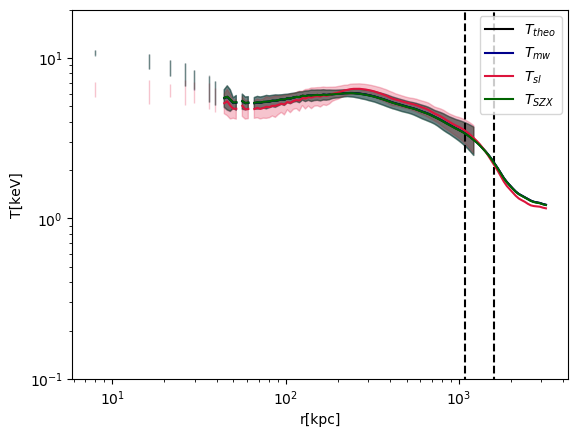

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(rbins_p, T500_theo, label='$T_{theo}$', color='k')
ax.loglog(rbins_p, T500_mw, label='$T_{mw}$', color='darkblue')
ax.loglog(rbins_p, T500_sl, label='$T_{sl}$', color='crimson')
ax.loglog(rbins_p, T500_szx, label='$T_{SZX}$', color='darkgreen')

ax.fill_between(rbins_p, T500_theo+T500_theo_err, T500_theo-T500_theo_err,  color='k', alpha=0.25)
ax.fill_between(rbins_p, T500_mw+T500_mw_err, T500_mw-T500_mw_err,  color='darkblue', alpha=0.25)
ax.fill_between(rbins_p, T500_sl+T500_sl_err, T500_sl-T500_sl_err,  color='crimson', alpha=0.25)
ax.fill_between(rbins_p, T500_szx+T500_szx_err, T500_szx-T500_szx_err,  color='darkgreen', alpha=0.25)

ax.vlines([r200, r500], 0., 20, color='k', ls='--')

ax.set_ylim(1e-1, 20)
ax.set_ylabel('T[keV]')
ax.set_xlabel('r[kpc]')

plt.legend()

# 3D profiles tests

In [84]:
nbins_3Dprofile = 150

xxx, yyy, zzz = np.meshgrid(np.linspace(-r200_frac*r200, r200_frac*r200, nbins),
                            np.linspace(-r200_frac*r200, r200_frac*r200, nbins),
                            np.linspace(-r200_frac*r200, r200_frac*r200, nbins))

dist = np.sqrt(xxx**2 + yyy**2 + zzz**2)

ne_3Dprofile = []
Te_3Dprofile = []
Pe_3Dprofile = []

ne_3D_err = []
Te_3D_err = []
Pe_3D_err = []

rbins_3D = np.logspace(np.log10(0.005*prop['r200']), np.log10(r200_frac*prop['r200']), num=nbins_3Dprofile+1)

In [85]:
ne_3Dprofile.append(np.nanmean(density_cube_sph[(dist<=rbins_3D[0])]))
Pe_3Dprofile.append(np.nanmean(pressure_cube_sph[(dist<=rbins_3D[0])]))
Te_3Dprofile.append(np.nanmean(temperature_cube_sph[(dist<=rbins_3D[0])]))

ne_3D_err.append(np.nanstd(density_cube_sph[(dist<=rbins_3D[0])]))
Pe_3D_err.append(np.nanstd(pressure_cube_sph[(dist<=rbins_3D[0])]))
Te_3D_err.append(np.nanstd(temperature_cube_sph[(dist<=rbins_3D[0])]))

for i, (rr0, rr1) in enumerate(zip(rbins_3D[:-1], rbins_3D[1:])):
    ne_3Dprofile = np.append(ne_3Dprofile, np.nanmean(density_cube_sph[(dist>rr0) & (dist<=rr1)]))
    Pe_3Dprofile = np.append(Pe_3Dprofile, np.nanmean(pressure_cube_sph[(dist>rr0) & (dist<=rr1)]))
    Te_3Dprofile = np.append(Te_3Dprofile, np.nanmean(temperature_cube_sph[(dist>rr0) & (dist<=rr1)]))

    ne_3D_err = np.append(ne_3D_err, np.nanstd(density_cube_sph[(dist>rr0) & (dist<=rr1)]))
    Pe_3D_err = np.append(Pe_3D_err, np.nanstd(pressure_cube_sph[(dist>rr0) & (dist<=rr1)]))
    Te_3D_err = np.append(Te_3D_err, np.nanstd(temperature_cube_sph[(dist>rr0) & (dist<=rr1)]))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 636 but corresponding boolean dimension is 860

No handles with labels found to put in legend.


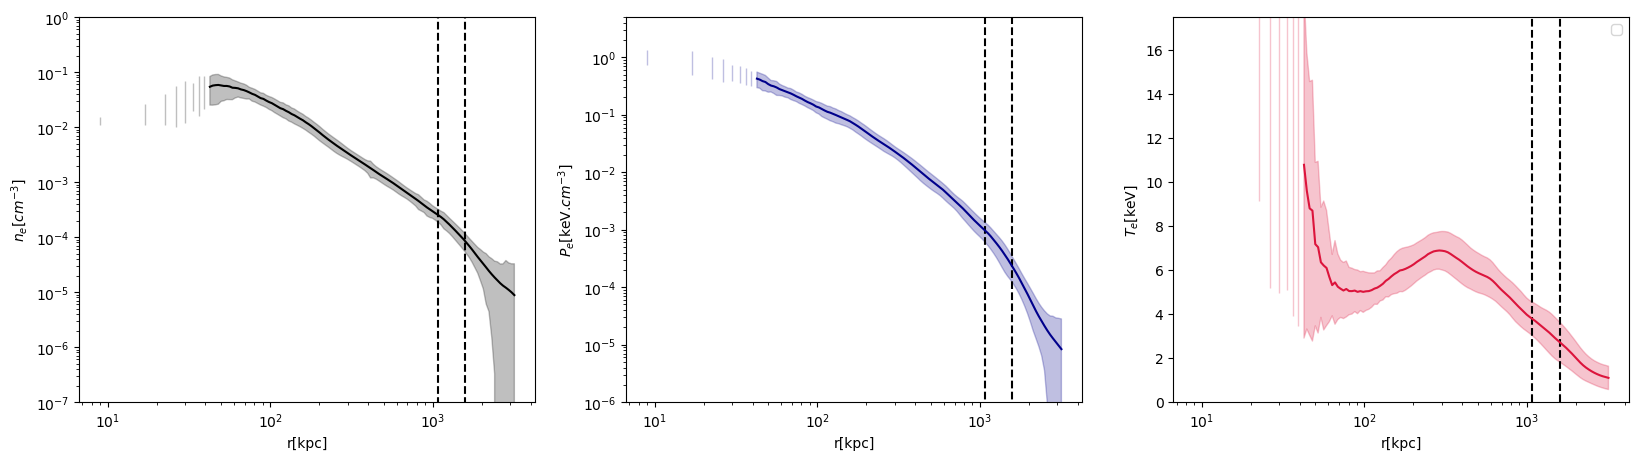

In [ ]:
fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(131)
ax1.loglog(rbins_3D, ne_3Dprofile, color='k')
ax1.fill_between(rbins_3D, ne_3Dprofile+ne_3D_err, ne_3Dprofile-ne_3D_err,  color='k', alpha=0.25)
ax1.vlines([r200, r500], 0., 20, color='k', ls='--')
ax1.set_ylim(1e-7, 1.)
ax1.set_ylabel('$n_e$[$cm^{-3}$]')
ax1.set_xlabel('r[kpc]')

ax2 = fig.add_subplot(132)
ax2.loglog(rbins_3D, Pe_3Dprofile, color='darkblue')
ax2.fill_between(rbins_3D, Pe_3Dprofile+Pe_3D_err, Pe_3Dprofile-Pe_3D_err,  color='darkblue', alpha=0.25)
ax2.vlines([r200, r500], 0., 20, color='k', ls='--')
ax2.set_ylim(1e-6, 5.)
ax2.set_ylabel('$P_e$[keV.$cm^{-3}$]')
ax2.set_xlabel('r[kpc]')

ax3 = fig.add_subplot(133)
ax3.plot(rbins_3D, Te_3Dprofile, color='crimson')
ax3.fill_between(rbins_3D, Te_3Dprofile+Te_3D_err, Te_3Dprofile-Te_3D_err,  color='crimson', alpha=0.25)
ax3.vlines([r200, r500], 0., 100, color='k', ls='--')
ax3.set_ylim(0., 17.5)
ax3.set_ylabel('$T_e$[keV]')
ax3.set_xlabel('r[kpc]')
ax3.set_xscale('log')

plt.legend()

In [ ]:
integrated_mass_profile = []

integrated_mass_profile.append(np.nansum(mass_cube_sph[dist<rbins_3D[0]]))
for i, (rr0, rr1) in enumerate(zip(rbins_3D[:-1], rbins_3D[1:])):
    integrated_mass_profile = np.append(integrated_mass_profile, np.nansum(mass_cube_sph[dist<=rr1]))

In [ ]:
non_smoothed_mass_cube = np.histogramdd([x,y,z], bins = (nbins, nbins, nbins), weights=mas)[0]

In [ ]:
non_smoothed_mass_profile = []

non_smoothed_mass_profile.append(np.nansum(non_smoothed_mass_cube[dist<rbins_3D[0]]))
for i, (rr0, rr1) in enumerate(zip(rbins_3D[:-1], rbins_3D[1:])):
    non_smoothed_mass_profile = np.append(non_smoothed_mass_profile, np.nansum(non_smoothed_mass_cube[dist<=rr1]))

Text(0.5, 0, 'r[kpc]')

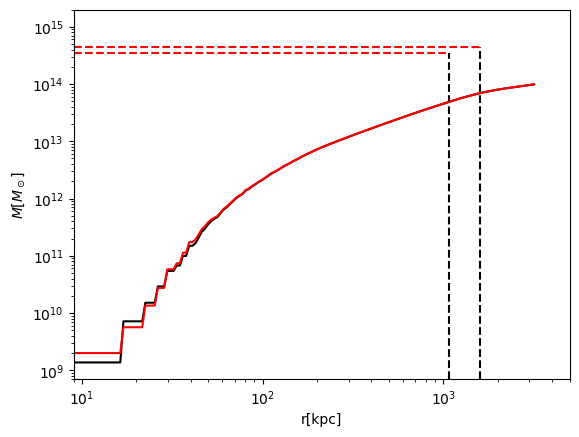

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.loglog(rbins_3D, integrated_mass_profile, color='k')
ax1.loglog(rbins_3D, non_smoothed_mass_profile, color='r')
#ax1.fill_between(rbins_3D, ne_3Dprofile+ne_3D_err, ne_3Dprofile-ne_3D_err,  color='k', alpha=0.25)
ax1.vlines(r500, 7e8, M500, color='k', ls='--')
ax1.vlines(r200, 7e8, M200, color='k', ls='--')
ax1.hlines(M500, 9, r500, color='r', ls='--')
ax1.hlines(M200, 9, r200, color='r', ls='--')
ax1.set_ylim(7e8, 2e15)
ax1.set_xlim(9, 5e3)
ax1.set_ylabel('$M$[$M_\odot$]')
ax1.set_xlabel('r[kpc]')

In [ ]:
gas_fraction_500 = np.sum(mass_cube_sph[dist<r500])/M500
gas_fraction_200 = np.sum(mass_cube_sph[dist<r200])/M200

print(gas_fraction_500, gas_fraction_200)

0.1392780657819826 0.15387268983697278


In [ ]:
non_smoothed_temp_cube = np.histogramdd([x,y,z], bins = (nbins, nbins, nbins), weights=temp)[0]
non_smoothed_part_cube = np.histogramdd([x,y,z], bins = (nbins, nbins, nbins))[0]
non_smoothed_temp_cube /= non_smoothed_part_cube

/tmp/ipykernel_1846526/2794901649.py:3: RuntimeWarning: divide by zero encountered in divide
  non_smoothed_temp_cube /= non_smoothed_part_cube
/tmp/ipykernel_1846526/2794901649.py:3: RuntimeWarning: invalid value encountered in divide
  non_smoothed_temp_cube /= non_smoothed_part_cube


In [ ]:
non_smoothed_temp_profile = []

non_smoothed_temp_profile.append(np.nanmean(non_smoothed_temp_cube[dist<rbins_3D[0]]))
for i, (rr0, rr1) in enumerate(zip(rbins_3D[:-1], rbins_3D[1:])):
    non_smoothed_temp_profile = np.append(non_smoothed_temp_profile, np.nanmean(non_smoothed_temp_cube[(dist>rr0) & (dist<=rr1)]))

/tmp/ipykernel_1846526/3743758819.py:3: RuntimeWarning: Mean of empty slice
  non_smoothed_temp_profile.append(np.nanmean(non_smoothed_temp_cube[dist<rbins_3D[0]]))
/tmp/ipykernel_1846526/3743758819.py:5: RuntimeWarning: Mean of empty slice
  non_smoothed_temp_profile = np.append(non_smoothed_temp_profile, np.nanmean(non_smoothed_temp_cube[(dist>rr0) & (dist<=rr1)]))


Text(0.5, 0, 'r[kpc]')

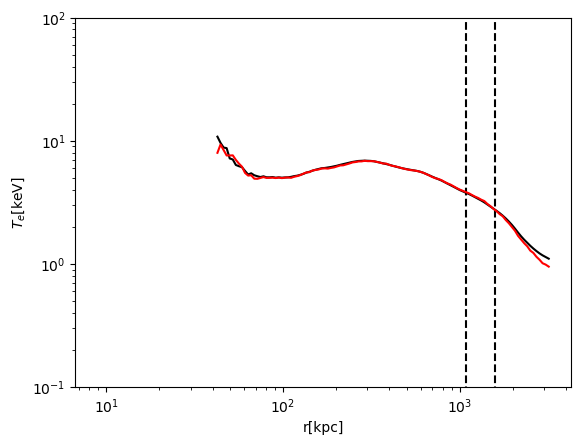

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.loglog(rbins_3D, Te_3Dprofile, color='k')
ax1.loglog(rbins_3D, non_smoothed_temp_profile, color='r')
#ax1.fill_between(rbins_3D, ne_3Dprofile+ne_3D_err, ne_3Dprofile-ne_3D_err,  color='k', alpha=0.25)
ax1.vlines(r500, 1e-5, 1e2, color='k', ls='--')
ax1.vlines(r200, 1e-5, 1e2, color='k', ls='--')
ax1.set_ylim(1e-1, 1e2,)
#ax1.set_xlim(9, 5e3)
ax1.set_ylabel('$T_e$[keV]')
ax1.set_xlabel('r[kpc]')

# Comparing the effect of the integration length in SPH cubes

In [151]:
ne_cube_3r200 = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_ne_map_3r200.npy')
bin_size_3r200 = (3*r200)/len(ne_cube_3r200)

ne_cube_7r200 = np.load(f'{sph_data_dir}/CL0282_snap107_sph_smoothed_ne_map_7r200.npy')#np.load(f'CL{crn:04d}_snap{sn}_test_sph_smoothed_ne_map_7.0r200.npy')
bin_size_7r200 = (7*r200)/len(ne_cube_7r200)

ne_cube_4r200 = np.load(f'{sph_data_dir}/CL{crn:04d}_snap{sn}_sph_smoothed_ne_map_4r200.npy')
bin_size_4r200 = (4*r200)/len(ne_cube_4r200)

In [152]:
bin_sizes = [bin_size_3r200, bin_size_4r200, bin_size_7r200]
cubes = [ne_cube_3r200, ne_cube_4r200, ne_cube_7r200]
int_lengths_r200 = [3, 4, 7]

In [153]:
leff_sph_profiles_list = []
leff_sph_errors_list = []
rbins_sph_list = []

for i, cube in enumerate(cubes):
    leff_sph_map = (np.sum(cube, axis=2)*bin_sizes[i])**2/(np.sum(cube**2, axis=2)*bin_sizes[i])

    nbins_prof = 150
    leff_sph_profile = []
    leff_sph_errors = []

    xx_sph, yy_sph = np.meshgrid(np.linspace(-int_lengths_r200[i]/2*r200, int_lengths_r200[i]/2*r200, len(cube)), 
                         np.linspace(-int_lengths_r200[i]/2*r200, int_lengths_r200[i]/2*r200, len(cube)))
    dist_sph = np.sqrt(xx_sph**2 + yy_sph**2)

    rbins_sph = np.logspace(np.log10(0.005*prop['r200']), np.log10(int_lengths_r200[i]*prop['r200']), num=nbins_prof+1)

    leff_sph_profile.append(np.nanmean(leff_sph_map[dist_sph<rbins_sph[0]]))
    leff_sph_errors.append(np.nanstd(leff_sph_map[dist_sph<rbins_sph[0]]))

    for i, (rr0, rr1) in enumerate(zip(rbins_sph[:-1], rbins_sph[1:])):
        leff_sph_profile = np.append(leff_sph_profile, np.nanmean(leff_sph_map[(dist_sph>rr0) & (dist_sph<=rr1)]))
        leff_sph_errors = np.append(leff_sph_errors, np.nanstd(leff_sph_map[(dist_sph>rr0) & (dist_sph<=rr1)]))
    
    leff_sph_profiles_list.append(leff_sph_profile)
    leff_sph_errors_list.append(leff_sph_errors)
    rbins_sph_list.append(rbins_sph)

np.save(f'list_of_sph_leff_profiles_CL{crn:04d}_snap{sn}.npy', leff_sph_profiles_list)
np.save(f'list_of_sph_leff_errors_CL{crn:04d}_snap{sn}.npy', leff_sph_errors_list)
np.save(f'list_of_sph_radial_bins_CL{crn:04d}_snap{sn}.npy', rbins_sph_list)

/tmp/ipykernel_3257331/215756091.py:22: RuntimeWarning: Mean of empty slice
  leff_sph_profile = np.append(leff_sph_profile, np.nanmean(leff_sph_map[(dist_sph>rr0) & (dist_sph<=rr1)]))
/home/rwicker/.conda/envs/Tszx_project/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3257331/215756091.py:18: RuntimeWarning: Mean of empty slice
  leff_sph_profile.append(np.nanmean(leff_sph_map[dist_sph<rbins_sph[0]]))


In [154]:
eff_leng_profiles = np.load(f'list_of_sph_leff_profiles_CL{crn:04d}_snap{sn}.npy')
eff_leng_errors = np.load(f'list_of_sph_leff_errors_CL{crn:04d}_snap{sn}.npy')
sph_radial_bins = np.load(f'list_of_sph_radial_bins_CL{crn:04d}_snap{sn}.npy')

colors = ['darkblue', 'darkgreen', 'crimson']
labels = [r'$3 \times R_{200}$', r'$4 \times R_{200}$', r'$7 \times R_{200}$']

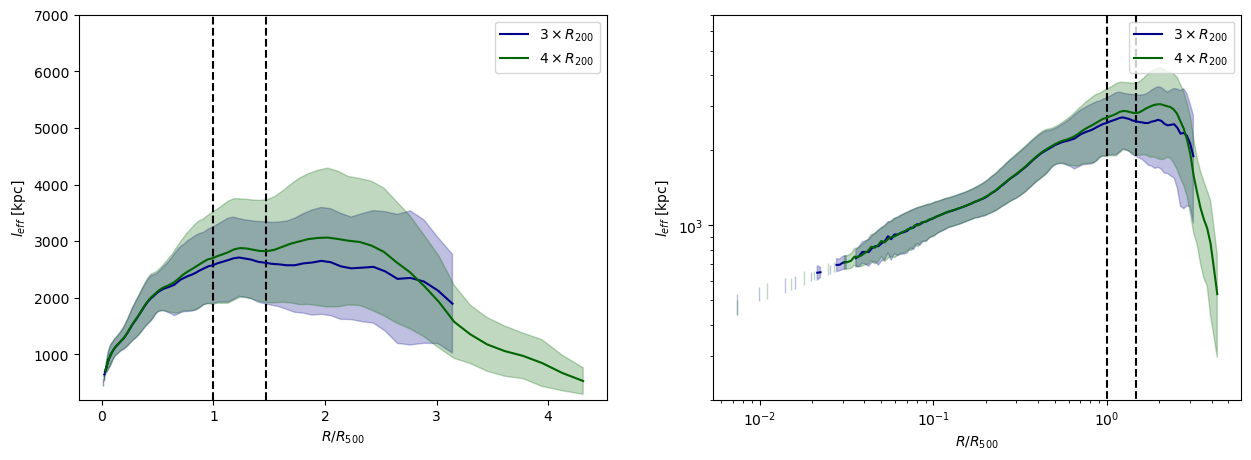

In [155]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
for i in range(3):
    if i==2 :
        continue
    ax1.plot(sph_radial_bins[i]/r500, eff_leng_profiles[i], color=colors[i], label=labels[i])
    ax1.fill_between(sph_radial_bins[i]/r500, eff_leng_profiles[i]+eff_leng_errors[i], 
                    eff_leng_profiles[i]-eff_leng_errors[i], color=colors[i], alpha=0.25)
ax1.set_xlabel('$R/R_{500}$')
ax1.set_ylabel('$l_{eff}$ [kpc]')
ax1.vlines([r500/r500, r200/r500], 1., 8e3, ls='--', colors='k')
ax1.set_ylim(2e2, 7e3)
plt.legend()

ax2 = plt.subplot(122)
for i in range(3):
    if i==2 :
        continue
    ax2.loglog(sph_radial_bins[i]/r500, eff_leng_profiles[i], color=colors[i], label=labels[i])
    ax2.fill_between(sph_radial_bins[i]/r500, eff_leng_profiles[i]+eff_leng_errors[i], 
                    eff_leng_profiles[i]-eff_leng_errors[i], color=colors[i], alpha=0.25)
ax2.set_xlabel('$R/R_{500}$')
ax2.set_ylabel('$l_{eff}$ [kpc]')
ax2.vlines([r500/r500, r200/r500], 1., 8e3, ls='--', colors='k')
ax2.set_ylim(2e2, 7e3)
plt.legend()

plt.savefig(f'{plot_dir}/integration_lengths_comparison_for_sph_CL{crn:04d}_snap{sn}.png')